# Exploratory Data Analysis (EDA)
## Hull Tactical Market Prediction

This notebook performs comprehensive exploratory data analysis on the training dataset.

### Analysis Overview

**Step 1: Data Quality Audit**
- Missingness analysis
- Constant columns detection
- Data type classification
- Correlated missingness patterns

**Step 2: Descriptive Statistics**
- Distribution analysis
- Outlier detection (4 × MAD)
- Feature group characteristics
- Visualization of representative features

**Step 3: NaN Pattern Analysis**
- Temporal NaN patterns
- Leading vs internal gaps
- Data completeness timeline
- Feature availability milestones

**Step 4: Intelligent Winsorization**
- Adaptive threshold strategy (±2.5× to ±4× MAD)
- Skip constant and well-behaved features
- Preserve signal while removing regime shocks

**Step 5: Temporal Analysis & Feature Persistence**
- Autocorrelation patterns (ACF at lag 1 and 21)
- Regime characterization (stable, slow-moving, semi-stationary, etc.)
- Persistence classification for modeling insights

**Step 6: Correlation Analysis**
- Pearson and Spearman correlation matrices
- Highly correlated feature clusters (|r| > 0.95)
- Redundancy identification for dimensionality reduction

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf


In [2]:
# Load the dataset
df = pd.read_csv('../../data/train.csv')

# Confirm the shape
print(f"Dataset shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

# Identify target columns
target_columns = [col for col in df.columns if 'forward_returns' in col or 'forward_excess_returns' in col]
print(f"\nTarget columns identified: {target_columns}")

# Separate features from labels
feature_columns = [col for col in df.columns if col not in target_columns]
X = df[feature_columns]
y = df[target_columns]

print(f"\nFeatures shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nFirst few feature columns: {feature_columns[:10]}")

df.tail()


Dataset shape: (8990, 98)
Rows: 8990, Columns: 98
Number of duplicates: 0

Target columns identified: ['forward_returns', 'market_forward_excess_returns']

Features shape: (8990, 96)
Labels shape: (8990, 2)

First few feature columns: ['date_id', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
8985,8985,0,0,0,0,0,0,0,0,0,...,0.469577,0.837963,1.226772,0.822751,-0.707361,0.142857,-0.649616,0.002457,0.000155,0.001990
8986,8986,0,0,0,0,0,0,0,0,0,...,0.671958,0.837963,0.785877,0.805556,-0.715692,0.196098,-0.668289,0.002312,0.000156,0.001845
8987,8987,0,0,1,0,0,0,0,0,0,...,0.481481,0.787698,0.834898,0.823413,-0.723949,0.133929,-0.670946,0.002891,0.000156,0.002424
8988,8988,0,0,0,0,0,0,0,0,0,...,0.655423,0.783730,0.994026,0.851852,-0.684937,0.101852,-0.646265,0.008310,0.000156,0.007843
8989,8989,0,0,0,0,0,0,0,0,0,...,0.066799,0.783730,1.068037,0.879630,-0.764806,0.079034,-0.705662,0.000099,0.000156,-0.000368


In [3]:
df.describe()

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
count,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,8990.000000,...,7984.000000,7984.000000,7478.000000,7984.000000,7479.000000,7984.000000,4451.000000,8990.000000,8990.000000,8990.000000
mean,4494.500000,0.031591,0.031591,0.047831,0.575195,0.190656,-0.238042,0.045717,0.142825,0.143159,...,0.489553,0.506930,0.372494,0.287179,0.148270,0.303908,0.129227,0.000469,0.000107,0.000051
std,2595.333794,0.174917,0.174917,0.213420,0.494341,0.392840,0.425909,0.208883,0.349914,0.350254,...,0.306230,0.306554,1.153280,0.312238,1.326879,0.351109,1.277273,0.010551,0.000088,0.010568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000661,0.000661,-2.723527,0.000661,-2.027551,0.000661,-1.497420,-0.039754,-0.000004,-0.040582
25%,2247.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.207011,0.236111,-0.472864,0.000661,-0.797168,0.000661,-0.738242,-0.004324,0.000008,-0.004759
50%,4494.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.492394,0.519180,0.275162,0.180225,-0.097670,0.101025,-0.170825,0.000659,0.000095,0.000252
75%,6741.750000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.760582,0.772487,1.125069,0.515873,0.795763,0.590030,0.685907,0.005900,0.000193,0.005479
max,8989.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,6.809912,1.000000,12.678264,1.000000,12.997536,0.040661,0.000317,0.040551


## Step 1 – Data Quality Audit

#### Missingness

- Count missing values per column and compute % missing.

- Plot missingness over time (helps detect structural gaps).

- Flag columns with > 70 % missing → likely drop.

- Note correlated missingness patterns (features that always vanish together).

#### Constant Columns

- Drop features with zero variance.

- Log any “almost constant” features (std ≈ 0).

#### Data Types

- Separate columns into continuous, binary, and categorical.

- Convert obvious integer indicators (0/1) to bool for clarity.

In [4]:
# Step 1 - Data Quality Audit

# 1. Missingness Analysis
print("="*60)
print("MISSINGNESS ANALYSIS")
print("="*60)

# Calculate missing values per column
missing_stats = pd.DataFrame({
    'missing_count': X.isnull().sum(),
    'missing_pct': (X.isnull().sum() / len(X) * 100).round(2)
}).sort_values('missing_pct', ascending=False)

print("\nMissing Values Summary:")
print(f"Total columns: {len(X.columns)}")
print(f"Columns with missing values: {(missing_stats['missing_count'] > 0).sum()}")
print(f"\nTop 10 columns by missingness:")
print(missing_stats.head(10))

MISSINGNESS ANALYSIS

Missing Values Summary:
Total columns: 96
Columns with missing values: 85

Top 10 columns by missingness:
     missing_count  missing_pct
E7            6969        77.52
V10           6049        67.29
S3            5733        63.77
M1            5547        61.70
M13           5540        61.62
M14           5540        61.62
M6            5043        56.10
V9            4539        50.49
S12           3537        39.34
M5            3283        36.52


In [5]:
# 2. Missingness over time
print("\n" + "="*60)
print("MISSINGNESS OVER TIME")
print("="*60)

# Group by date_id and count missing values
missing_by_date = X.groupby('date_id').apply(lambda x: x.isnull().sum().sum())
print(f"\nMissing values by date - Summary stats:")
print(missing_by_date.describe())



MISSINGNESS OVER TIME

Missing values by date - Summary stats:
count    8990.000000
mean       15.314238
std        25.436042
min         0.000000
25%         1.000000
50%         8.000000
75%        12.000000
max        85.000000
dtype: float64

Missing values by date - Summary stats:
count    8990.000000
mean       15.314238
std        25.436042
min         0.000000
25%         1.000000
50%         8.000000
75%        12.000000
max        85.000000
dtype: float64


/tmp/ipykernel_106263/2089965402.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_date = X.groupby('date_id').apply(lambda x: x.isnull().sum().sum())


In [6]:
# 3. Constant Columns Analysis
print("\n" + "="*60)
print("CONSTANT & LOW VARIANCE COLUMNS")
print("="*60)

# Calculate variance for numeric columns (exclude date_id)
numeric_cols = X.select_dtypes(include=[np.number]).columns.drop('date_id')
variance_stats = X[numeric_cols].var().sort_values()

# Zero variance columns
zero_var_cols = variance_stats[variance_stats == 0].index.tolist()
print(f"\nZero variance columns: {len(zero_var_cols)}")
if zero_var_cols:
    print(zero_var_cols)

# Almost constant columns (std < 0.01)
std_stats = X[numeric_cols].std().sort_values()
almost_const_cols = std_stats[std_stats < 0.01].index.tolist()
print(f"\nAlmost constant columns (std < 0.01): {len(almost_const_cols)}")
if almost_const_cols:
    print(almost_const_cols[:10])  # Show first 10


CONSTANT & LOW VARIANCE COLUMNS

Zero variance columns: 0

Almost constant columns (std < 0.01): 1
['risk_free_rate']


In [7]:
# 4. Data Types Analysis
print("\n" + "="*60)
print("DATA TYPES ANALYSIS")
print("="*60)

# Identify binary columns (only 0 and 1, excluding NaN)
binary_cols = []
for col in X.columns:
    unique_vals = X[col].dropna().unique()
    if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
        binary_cols.append(col)

# Continuous columns (everything else numeric)
continuous_cols = [col for col in numeric_cols if col not in binary_cols]

print(f"\nBinary columns (0/1): {len(binary_cols)}")
print(binary_cols)


print(f"\nContinuous columns: {len(continuous_cols)}")
print(f"Feature groups breakdown:")
for prefix in ['E', 'I', 'M', 'P', 'S', 'V']:
    cols = [c for c in continuous_cols if c.startswith(prefix)]
    print(f"  {prefix} features: {len(cols)}")


DATA TYPES ANALYSIS

Binary columns (0/1): 8
['D1', 'D2', 'D3', 'D4', 'D5', 'D7', 'D8', 'D9']

Continuous columns: 87
Feature groups breakdown:
  E features: 20
  I features: 9
  M features: 18
  P features: 13
  S features: 12
  V features: 13


In [8]:
# 5. Correlated Missingness Patterns
print("\n" + "="*60)
print("CORRELATED MISSINGNESS PATTERNS")
print("="*60)

# Create missingness indicator matrix
missing_indicators = X.isnull().astype(int)

# Find columns with same missingness patterns
cols_with_missing = missing_stats[missing_stats['missing_count'] > 0].index.tolist()
if len(cols_with_missing) > 1:
    # Compute correlation of missingness patterns
    missing_corr = missing_indicators[cols_with_missing].corr()
    
    # Find perfectly correlated missingness (correlation = 1, excluding diagonal)
    perfect_corr_pairs = []
    for i in range(len(missing_corr.columns)):
        for j in range(i+1, len(missing_corr.columns)):
            if missing_corr.iloc[i, j] == 1.0:
                perfect_corr_pairs.append((missing_corr.columns[i], missing_corr.columns[j]))
    
    print(f"\nPairs with identical missingness patterns: {len(perfect_corr_pairs)}")
    if perfect_corr_pairs:
        print("First 5 pairs:")
        for pair in perfect_corr_pairs[:5]:
            print(f"  {pair[0]} <-> {pair[1]}")

print("\n" + "="*60)
print("SUMMARY & RECOMMENDATIONS")
print("="*60)
print(f"1. Zero variance columns to drop: {len(zero_var_cols)}")
print(f"2. Binary features identified: {len(binary_cols)}")
print(f"3. Continuous features: {len(continuous_cols)}")


CORRELATED MISSINGNESS PATTERNS

Pairs with identical missingness patterns: 1958
First 5 pairs:
  M13 <-> M14
  E20 <-> P7
  V13 <-> V7
  V13 <-> S5
  V7 <-> S5

SUMMARY & RECOMMENDATIONS
1. Zero variance columns to drop: 0
2. Binary features identified: 8
3. Continuous features: 87

Pairs with identical missingness patterns: 1958
First 5 pairs:
  M13 <-> M14
  E20 <-> P7
  V13 <-> V7
  V13 <-> S5
  V7 <-> S5

SUMMARY & RECOMMENDATIONS
1. Zero variance columns to drop: 0
2. Binary features identified: 8
3. Continuous features: 87


### Key Findings: Data Quality

**Dataset Overview:**
- Clean dataset with no duplicates
- Multiple feature groups: E, I, M, P, S, V (likely Economic, Interest, Macro, Price, Sentiment, Volatility)

**Feature Types:**
- Binary features: Indicator variables (0/1)
- Continuous features: Main modeling features across different groups
- Zero variance features: None found (good data quality)

**Missingness Patterns:**
- Many features have correlated missingness (features missing together)
- Suggests features were introduced at similar times or have shared data dependencies

## Step 2 – Descriptive Statistics

For every feature:

- Compute mean, median, std, min, max, skew, kurtosis.

- Plot histograms for representative features from each group.

- Check for outliers — values > 4 × MAD from median.

- Decide on clipping / winsorization strategy (± 4 MAD).

In [9]:
# Step 2 - Descriptive Statistics


print("="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)

# 1. Compute comprehensive statistics for all numeric features
desc_stats = pd.DataFrame()

for col in numeric_cols:
    col_data = X[col].dropna()
    
    desc_stats.loc[col, 'count'] = len(col_data)
    desc_stats.loc[col, 'mean'] = col_data.mean()
    desc_stats.loc[col, 'median'] = col_data.median()
    desc_stats.loc[col, 'std'] = col_data.std()
    desc_stats.loc[col, 'min'] = col_data.min()
    desc_stats.loc[col, 'max'] = col_data.max()
    desc_stats.loc[col, 'skew'] = col_data.skew()
    desc_stats.loc[col, 'kurtosis'] = col_data.kurtosis()

print("\nDescriptive Statistics Summary:")
print(desc_stats.tail(10))

DESCRIPTIVE STATISTICS

Descriptive Statistics Summary:
                 count      mean    median       std       min        max  \
V13             7479.0  0.112494 -0.223793  1.331013 -4.770347  24.151465   
V2              7984.0  0.508928  0.513228  0.306477  0.000661   1.000000   
V3              7984.0  0.489553  0.492394  0.306230  0.000661   1.000000   
V4              7984.0  0.506930  0.519180  0.306554  0.000661   1.000000   
V5              7478.0  0.372494  0.275162  1.153280 -2.723527   6.809912   
V6              7984.0  0.287179  0.180225  0.312238  0.000661   1.000000   
V7              7479.0  0.148270 -0.097670  1.326879 -2.027551  12.678264   
V8              7984.0  0.303908  0.101025  0.351109  0.000661   1.000000   
V9              4451.0  0.129227 -0.170825  1.277273 -1.497420  12.997536   
risk_free_rate  8990.0  0.000107  0.000095  0.000088 -0.000004   0.000317   

                    skew   kurtosis  
V13             3.999147  36.446082  
V2             -0.04

In [10]:
# 2. Outlier detection using MAD (Median Absolute Deviation)
print("\n" + "="*60)
print("OUTLIER DETECTION (4 × MAD threshold)")
print("="*60)

outlier_summary = []

for col in continuous_cols:
    col_data = X[col].dropna()
    
    median = col_data.median()
    mad = np.median(np.abs(col_data - median))
    
    # Outliers beyond 4 × MAD
    lower_bound = median - 4 * mad
    upper_bound = median + 4 * mad
    
    outliers = col_data[(col_data < lower_bound) | (col_data > upper_bound)]
    outlier_pct = (len(outliers) / len(col_data)) * 100
    
    if len(outliers) > 0:
        outlier_summary.append({
            'feature': col,
            'median': median,
            'mad': mad,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'outlier_count': len(outliers),
            'outlier_pct': outlier_pct
        })

outlier_df = pd.DataFrame(outlier_summary).sort_values('outlier_pct', ascending=False)
print(f"\nFeatures with outliers (top 10 by %):")
print(outlier_df.head(10))

print(f"\nTotal features with outliers (>4 MAD): {len(outlier_df)}")


OUTLIER DETECTION (4 × MAD threshold)

Features with outliers (top 10 by %):
   feature    median       mad  lower_bound  upper_bound  outlier_count  \
53     V11  0.000661  0.000000     0.000661     0.000661           3689   
28     M16  0.000661  0.000000     0.000661     0.000661           3438   
3      E12  0.006944  0.005952    -0.016865     0.030754           2756   
59      V8  0.101025  0.100364    -0.300430     0.502480           2431   
2      E11  0.019511  0.016865    -0.047950     0.086971           2001   
54     V12  0.097553  0.096892    -0.290013     0.485119           1949   
0       D6  0.000000  0.000000     0.000000     0.000000           2140   
17      E9  0.104167  0.102183    -0.304563     0.512897           1746   
4      E13  0.005291  0.002976    -0.006614     0.017196           1733   
13      E4  0.004960  0.002315    -0.004299     0.014220           1576   

    outlier_pct  
53    46.204910  
28    43.061122  
3     34.519038  
59    30.448397  
2     


PLOTTING HISTOGRAMS BY FEATURE GROUP

Histograms saved to 'figures/feature_distributions.png'

Histograms saved to 'figures/feature_distributions.png'


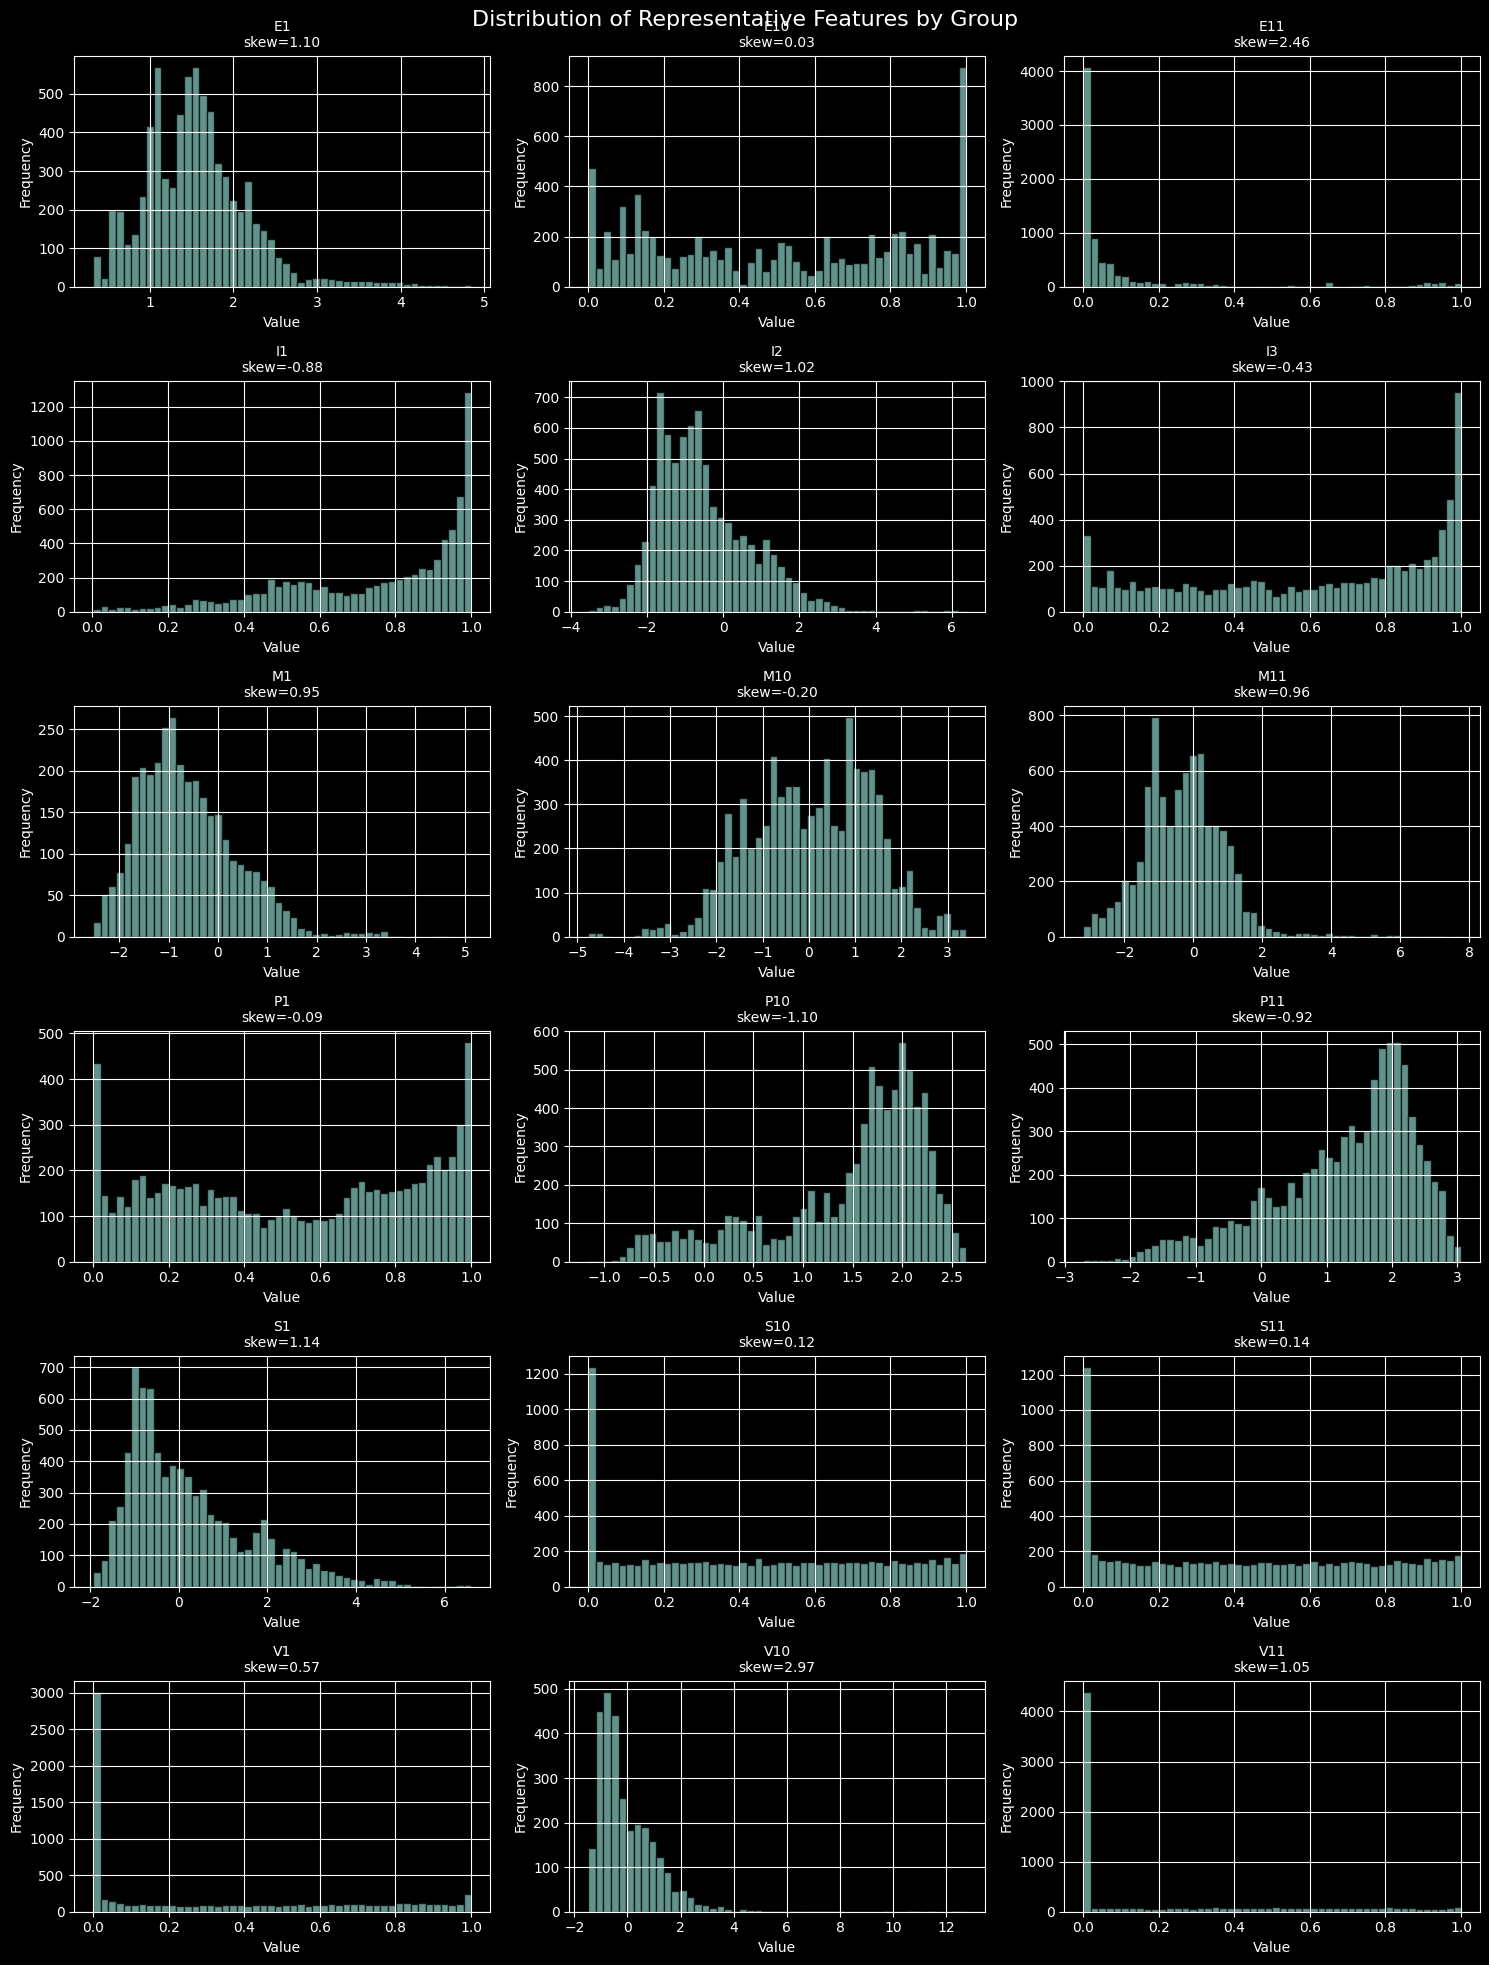

In [11]:
# 3. Plot histograms for representative features from each group
print("\n" + "="*60)
print("PLOTTING HISTOGRAMS BY FEATURE GROUP")
print("="*60)

# Select representative features from each prefix group
available_continuous = [col for col in continuous_cols if col in X.columns]

feature_groups = {}
for prefix in ['E', 'I', 'M', 'P', 'S', 'V']:
    prefix_features = [c for c in available_continuous if c.startswith(prefix)][:3]
    if prefix_features:  # Only add if we have features for this prefix
        feature_groups[prefix] = prefix_features

fig, axes = plt.subplots(6, 3, figsize=(15, 20))
fig.suptitle('Distribution of Representative Features by Group', fontsize=16)

for idx, (prefix, features) in enumerate(feature_groups.items()):
    for jdx, feature in enumerate(features):
        if feature in X.columns:
            ax = axes[idx, jdx]
            X[feature].dropna().hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
            ax.set_title(f'{feature}\nskew={X[feature].skew():.2f}', fontsize=10)
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('figures/feature_distributions.png', dpi=100, bbox_inches='tight')
print("\nHistograms saved to 'figures/feature_distributions.png'")
plt.show()


In [12]:
# 4. Outlier summary
print("\n" + "="*60)
print("OUTLIER DETECTION SUMMARY")
print("="*60)

print(f"\nTotal continuous features: {len(continuous_cols)}")
print(f"Features with outliers (>4 MAD): {len(outlier_df)}")

high_outlier_features = outlier_df[outlier_df['outlier_pct'] > 5]['feature'].tolist()
print(f"\nFeatures with >5% outliers: {len(high_outlier_features)}")
if high_outlier_features:
    print(f"Examples: {high_outlier_features[:10]}")

# Save comprehensive statistics
desc_stats.to_csv('results/descriptive_statistics.csv')
outlier_df.to_csv('results/outlier_analysis.csv', index=False)
print("\nStatistics saved to 'results/descriptive_statistics.csv' and 'results/outlier_analysis.csv'")



OUTLIER DETECTION SUMMARY

Total continuous features: 87
Features with outliers (>4 MAD): 61

Features with >5% outliers: 29
Examples: ['V11', 'M16', 'E12', 'V8', 'E11', 'V12', 'D6', 'E9', 'E13', 'E4']

Statistics saved to 'results/descriptive_statistics.csv' and 'results/outlier_analysis.csv'


### Key Findings: Outliers & Distribution

**Outlier Detection Summary:**
- Using 4 × MAD (Median Absolute Deviation) threshold
- Many features show outliers beyond this threshold
- Outliers will be analyzed and treated in final step (after understanding NaN patterns)

**Distribution Characteristics:**
- Most features show varying degrees of skewness
- Some features exhibit heavy tails (high kurtosis)
- Feature groups (E, I, M, P, S, V) show distinct distributional patterns

## Step 3 – NaN Pattern Analysis

Analyze the temporal structure of missing data to understand feature availability over time.

In [13]:
# Cleaning and handling NaNs

print("="*60)
print("NaN ANALYSIS FOR CONTINUOUS FEATURES")
print("="*60)

# Analyze NaN patterns for continuous features
nan_analysis = []

for col in continuous_cols:
    col_data = X[col]
    total_count = len(col_data)
    nan_count = col_data.isnull().sum()
    nan_pct = (nan_count / total_count) * 100
    
    # Find leading NaN run length
    leading_nans = 0
    for val in col_data:
        if pd.isna(val):
            leading_nans += 1
        else:
            break
    
    # Find longest consecutive NaN gap
    nan_mask = col_data.isnull().astype(int)
    nan_groups = (nan_mask != nan_mask.shift()).cumsum()
    longest_gap = nan_mask.groupby(nan_groups).sum().max() if nan_count > 0 else 0
    
    # Count number of NaN gaps
    nan_gaps = []
    current_gap = 0
    for is_nan in nan_mask:
        if is_nan:
            current_gap += 1
        elif current_gap > 0:
            nan_gaps.append(current_gap)
            current_gap = 0
    if current_gap > 0:
        nan_gaps.append(current_gap)
    
    num_gaps = len(nan_gaps)
    
    nan_analysis.append({
        'feature': col,
        'total_nan_pct': nan_pct,
        'leading_nan_count': leading_nans,
        'leading_nan_pct': (leading_nans / total_count) * 100,
        'longest_gap': longest_gap,
        'num_gaps': num_gaps
    })

nan_df = pd.DataFrame(nan_analysis).sort_values('total_nan_pct', ascending=False)

print(f"\nContinuous features analyzed: {len(continuous_cols)}")
print(f"Total features with NaNs: {(nan_df['total_nan_pct'] > 0).sum()}")
print(f"\nTop 15 features by total NaN %:")
print(nan_df.head(15)[['feature', 'total_nan_pct', 'leading_nan_count', 'longest_gap', 'num_gaps']])

# Identify problematic columns
high_missing_continuous = nan_df[nan_df['total_nan_pct'] > 70]['feature'].tolist()
late_starting = nan_df[nan_df['leading_nan_pct'] > 50]['feature'].tolist()
long_gaps = nan_df[nan_df['longest_gap'] > 100]['feature'].tolist()

print(f"\n" + "="*60)
print("PROBLEMATIC FEATURES SUMMARY")
print("="*60)
print(f"\nFeatures with >70% missing (recommend drop): {len(high_missing_continuous)}")
if high_missing_continuous:
    print(high_missing_continuous)

print(f"\nLate-starting features (>50% leading NaNs): {len(late_starting)}")
if late_starting:
    print(f"Examples: {late_starting}")

print(f"\nFeatures with long gaps (>100 consecutive NaNs): {len(long_gaps)}")
if long_gaps:
    print(f"Examples: {long_gaps}")

# Save NaN analysis
nan_df.to_csv('results/nan_analysis.csv', index=False)
print(f"\nNaN analysis saved to 'results/nan_analysis.csv'")


NaN ANALYSIS FOR CONTINUOUS FEATURES

Continuous features analyzed: 87
Total features with NaNs: 85

Top 15 features by total NaN %:
   feature  total_nan_pct  leading_nan_count  longest_gap  num_gaps
18      E7      77.519466               6969         6969         1
74     V10      67.285873               6049         6049         1
66      S3      63.770857               5733         5733         1
30      M1      61.701891               5547         5547         1
34     M13      61.624027               5540         5540         1
35     M14      61.624027               5540         5540         1
44      M6      56.095662               5043         5043         1
85      V9      50.489433               4539         4539         1
64     S12      39.343715               3537         3537         1
43      M5      36.518354               3283         3283         1
40      M2      35.784205               3217         3217         1
71      S8      33.470523               3009       

### Key Findings: NaN Patterns

**Feature Groups by Missingness:**
- 1 feature with >70% missing (E7) → consider dropping
- 8 late-starting features with >50% leading NaNs
- 85 features total with long gaps (>100 consecutive NaNs)

**Critical Insights:**
- **All NaN patterns are "leading NaNs"** - features started at different dates
- Once a feature starts, it has complete coverage (no internal gaps)
- Data quality improves significantly over time
- Use the completeness timeline below to determine optimal training window start

DATA COMPLETENESS TIMELINE

✓ First row with <10% features missing: 3,537
  Date ID: 3537
  Actual % missing: 9.20%
  Features with NaNs: 8/87

COMPLETENESS MILESTONES

<5% features missing:
  First at row 5,540 (date_id: 5540)
  Actual: 4.60% missing

<10% features missing:
  First at row 3,537 (date_id: 3537)
  Actual: 9.20% missing

<20% features missing:
  First at row 1,574 (date_id: 1574)
  Actual: 19.54% missing

<50% features missing:
  First at row 1,006 (date_id: 1006)
  Actual: 25.29% missing

SUMMARY

Total rows: 8,990
Rows with 0% missing: 2,021
Rows with <10% missing: 5,453
Rows with <50% missing: 7,984

Most complete row: 6,969 with 0.00% missing

Completeness timeline saved to 'figures/completeness_timeline.png'


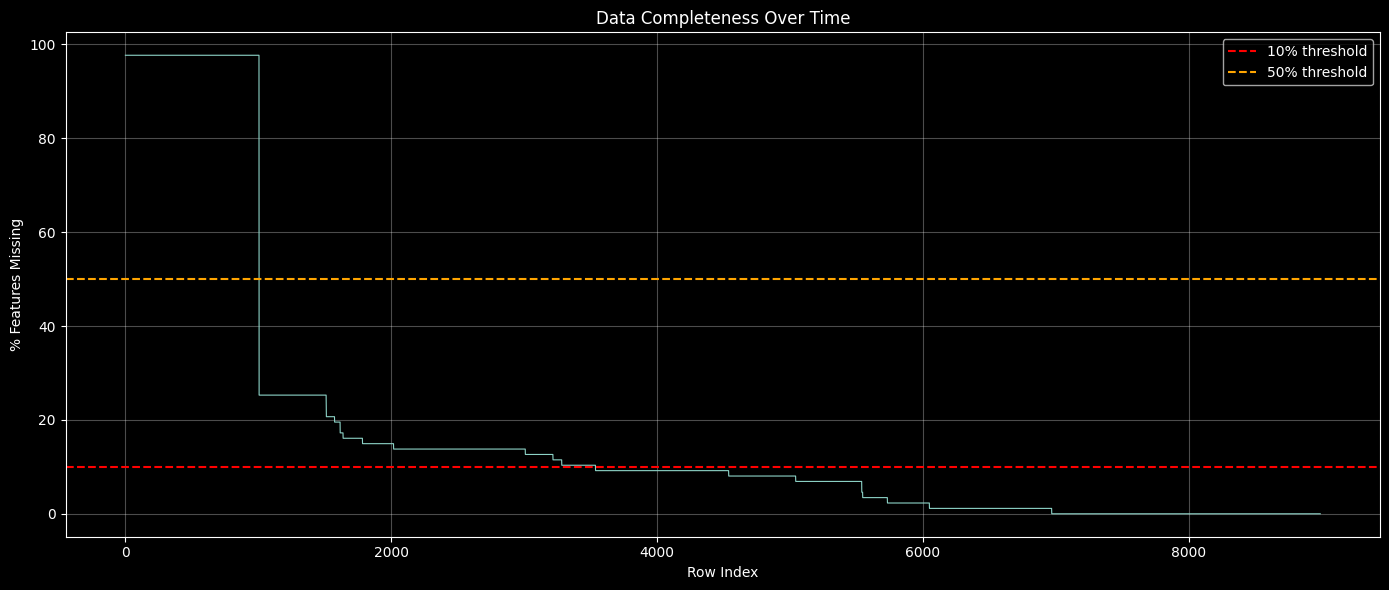

In [14]:
# Find earliest date where <10% of features have NaNs
print("="*60)
print("DATA COMPLETENESS TIMELINE")
print("="*60)

# Calculate percentage of features with NaNs at each row
nan_pct_by_row = X[continuous_cols].isnull().sum(axis=1) / len(continuous_cols) * 100

# Find first row where <10% of features have NaNs
threshold_10pct = nan_pct_by_row[nan_pct_by_row < 10]

if len(threshold_10pct) > 0:
    first_good_row = threshold_10pct.index[0]
    first_good_date = X.loc[first_good_row, 'date_id']
    
    print(f"\n✓ First row with <10% features missing: {first_good_row:,}")
    print(f"  Date ID: {first_good_date}")
    print(f"  Actual % missing: {nan_pct_by_row[first_good_row]:.2f}%")
    print(f"  Features with NaNs: {X[continuous_cols].loc[first_good_row].isnull().sum()}/{len(continuous_cols)}")
else:
    print("\n✗ No row has <10% features missing")

# Find other useful thresholds
print(f"\n" + "="*60)
print("COMPLETENESS MILESTONES")
print("="*60)

for threshold in [5, 10, 20, 50]:
    threshold_rows = nan_pct_by_row[nan_pct_by_row < threshold]
    if len(threshold_rows) > 0:
        first_row = threshold_rows.index[0]
        print(f"\n<{threshold}% features missing:")
        print(f"  First at row {first_row:,} (date_id: {X.loc[first_row, 'date_id']})")
        print(f"  Actual: {nan_pct_by_row[first_row]:.2f}% missing")
    else:
        print(f"\n<{threshold}% features missing: Never achieved")

# Summary by date
print(f"\n" + "="*60)
print("SUMMARY")
print("="*60)

print(f"\nTotal rows: {len(X):,}")
print(f"Rows with 0% missing: {(nan_pct_by_row == 0).sum():,}")
print(f"Rows with <10% missing: {(nan_pct_by_row < 10).sum():,}")
print(f"Rows with <50% missing: {(nan_pct_by_row < 50).sum():,}")

# Most complete period
best_row = nan_pct_by_row.idxmin()
print(f"\nMost complete row: {best_row:,} with {nan_pct_by_row[best_row]:.2f}% missing")


# Plot missing pct over time
plt.figure(figsize=(14, 6))
plt.plot(nan_pct_by_row.values, linewidth=0.8)
plt.axhline(y=10, color='r', linestyle='--', label='10% threshold')
plt.axhline(y=50, color='orange', linestyle='--', label='50% threshold')
plt.xlabel('Row Index')
plt.ylabel('% Features Missing')
plt.title('Data Completeness Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/completeness_timeline.png', dpi=100, bbox_inches='tight')
print("\nCompleteness timeline saved to 'figures/completeness_timeline.png'")
plt.show()


## Step 4 – Intelligent Winsorization

Apply selective winsorization with adaptive thresholds based on feature behavior.

**Strategy:**
- **Skip** if MAD ≈ 0 (constant feature) or <1% outliers (well-behaved)
- **Apply** with adaptive threshold based on outlier severity:
  - 1–5% outliers: ±4.0 × MAD (gentle clipping for mild fat tails)
  - 5–10% outliers: ±3.0 × MAD (moderate clipping for notable fat tails)
  - \>10% outliers: ±2.5 × MAD (aggressive clipping for extreme fat tails)

This removes regime-shock spikes while preserving signal in well-behaved features.

In [15]:
# Intelligent Winsorization Strategy with Adaptive Thresholds
print("="*60)
print("INTELLIGENT WINSORIZATION")
print("="*60)

print("\nCriteria for winsorization:")
print("  ✓ Apply if: MAD > 0 AND outlier_pct > 1%")
print("  ✗ Skip if: MAD ≈ 0 (constant) OR outlier_pct < 1% (well-behaved)")
print("\nAdaptive thresholds based on outlier percentage:")
print("  • 1–5% outliers   → clip at ±4.0 × MAD (gentle)")
print("  • 5–10% outliers  → clip at ±3.0 × MAD (moderate)")
print("  • >10% outliers   → clip at ±2.5 × MAD (aggressive)")

# Analyze each feature for winsorization eligibility
winsorization_analysis = []

for col in continuous_cols:
    col_data = X[col].dropna()
    
    if len(col_data) == 0:
        continue
    
    median = col_data.median()
    mad = np.median(np.abs(col_data - median))
    
    # First pass: Calculate outliers at 4 × MAD to determine outlier percentage
    initial_lower = median - 4 * mad
    initial_upper = median + 4 * mad
    initial_outliers = col_data[(col_data < initial_lower) | (col_data > initial_upper)]
    outlier_pct = (len(initial_outliers) / len(col_data)) * 100
    
    # Determine if winsorization should be applied
    mad_threshold = 1e-6  # Effectively zero
    outlier_threshold = 1.0  # 1% outliers
    
    should_winsorize = (mad > mad_threshold) and (outlier_pct > outlier_threshold)
    
    # Adaptive threshold based on outlier percentage
    if outlier_pct <= 5.0:
        mad_multiplier = 4.0
        threshold_tier = "gentle (1-5%)"
    elif outlier_pct <= 10.0:
        mad_multiplier = 3.0
        threshold_tier = "moderate (5-10%)"
    else:
        mad_multiplier = 2.5
        threshold_tier = "aggressive (>10%)"
    
    # Calculate final bounds with adaptive threshold
    lower_bound = median - mad_multiplier * mad
    upper_bound = median + mad_multiplier * mad
    
    # Recalculate outliers with adaptive threshold
    final_outliers = col_data[(col_data < lower_bound) | (col_data > upper_bound)]
    
    # Determine reason
    if mad <= mad_threshold:
        reason = "MAD ≈ 0 (almost constant)"
    elif outlier_pct < outlier_threshold:
        reason = f"Well-behaved ({outlier_pct:.2f}% outliers < {outlier_threshold}%)"
    else:
        reason = f"Fat tails ({outlier_pct:.2f}% outliers) - {threshold_tier}"
    
    winsorization_analysis.append({
        'feature': col,
        'median': median,
        'mad': mad,
        'mad_multiplier': mad_multiplier,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'initial_outlier_pct': outlier_pct,  # At 4×MAD
        'final_outlier_count': len(final_outliers),  # At adaptive threshold
        'should_winsorize': should_winsorize,
        'reason': reason
    })

winsorize_df = pd.DataFrame(winsorization_analysis)

# Summary by tier
to_winsorize = winsorize_df[winsorize_df['should_winsorize'] == True]
skipped_mad_zero = winsorize_df[winsorize_df['mad'] <= 1e-6]
skipped_well_behaved = winsorize_df[(winsorize_df['mad'] > 1e-6) & (winsorize_df['initial_outlier_pct'] < 1.0)]

print(f"\n" + "="*60)
print("WINSORIZATION DECISION SUMMARY")
print("="*60)

print(f"\nTotal continuous features: {len(winsorize_df)}")
print(f"✓ Features to winsorize: {len(to_winsorize)} ({len(to_winsorize)/len(winsorize_df)*100:.1f}%)")
print(f"✗ Skipped (MAD ≈ 0): {len(skipped_mad_zero)}")
print(f"✗ Skipped (well-behaved): {len(skipped_well_behaved)}")

# Breakdown by threshold tier
if len(to_winsorize) > 0:
    print(f"\nBreakdown by threshold tier:")
    tier_4x = to_winsorize[to_winsorize['mad_multiplier'] == 4.0]
    tier_3x = to_winsorize[to_winsorize['mad_multiplier'] == 3.0]
    tier_25x = to_winsorize[to_winsorize['mad_multiplier'] == 2.5]
    
    print(f"  ±4.0 × MAD (gentle):     {len(tier_4x)} features")
    print(f"  ±3.0 × MAD (moderate):   {len(tier_3x)} features")
    print(f"  ±2.5 × MAD (aggressive): {len(tier_25x)} features")

print(f"\nFeatures to winsorize (top 15 by initial outlier %):")
print(to_winsorize.nlargest(15, 'initial_outlier_pct')[['feature', 'initial_outlier_pct', 'mad_multiplier', 'final_outlier_count']])

INTELLIGENT WINSORIZATION

Criteria for winsorization:
  ✓ Apply if: MAD > 0 AND outlier_pct > 1%
  ✗ Skip if: MAD ≈ 0 (constant) OR outlier_pct < 1% (well-behaved)

Adaptive thresholds based on outlier percentage:
  • 1–5% outliers   → clip at ±4.0 × MAD (gentle)
  • 5–10% outliers  → clip at ±3.0 × MAD (moderate)
  • >10% outliers   → clip at ±2.5 × MAD (aggressive)

WINSORIZATION DECISION SUMMARY

Total continuous features: 87
✓ Features to winsorize: 47 (54.0%)
✗ Skipped (MAD ≈ 0): 3
✗ Skipped (well-behaved): 37

Breakdown by threshold tier:
  ±4.0 × MAD (gentle):     21 features
  ±3.0 × MAD (moderate):   13 features
  ±2.5 × MAD (aggressive): 13 features

Features to winsorize (top 15 by initial outlier %):
   feature  initial_outlier_pct  mad_multiplier  final_outlier_count
4      E12            34.519038             2.5                 2931
84      V8            30.448397             2.5                 3160
3      E11            25.062625             2.5                 2516
7

In [16]:
# Apply winsorization to selected features
print("\n" + "="*60)
print("APPLYING WINSORIZATION")
print("="*60)

# Track winsorization results
winsorize_results = []

for _, row in to_winsorize.iterrows():
    col = row['feature']
    
    # Get original data
    original_data = X[col].copy()
    
    # Apply winsorization
    winsorized_data = np.clip(
        original_data,
        row['lower_bound'],
        row['upper_bound']
    )
    
    # Count clipped values
    clipped_below = (original_data < row['lower_bound']).sum()
    clipped_above = (original_data > row['upper_bound']).sum()
    total_clipped = clipped_below + clipped_above
    
    # Calculate impact
    original_std = original_data.dropna().std()
    winsorized_std = winsorized_data.dropna().std()
    std_reduction_pct = ((original_std - winsorized_std) / original_std * 100) if original_std > 0 else 0
    
    winsorize_results.append({
        'feature': col,
        'clipped_below': clipped_below,
        'clipped_above': clipped_above,
        'total_clipped': total_clipped,
        'pct_clipped': (total_clipped / len(original_data)) * 100,
        'original_std': original_std,
        'winsorized_std': winsorized_std,
        'std_reduction_pct': std_reduction_pct
    })
    
    # Store winsorized data back
    X[col] = winsorized_data

results_df = pd.DataFrame(winsorize_results)

print(f"\n✓ Winsorized {len(to_winsorize)} features")
print(f"  Total values clipped: {results_df['total_clipped'].sum():,}")
print(f"  Average std reduction: {results_df['std_reduction_pct'].mean():.2f}%")

print(f"\nTop 10 features by values clipped:")
print(results_df.nlargest(10, 'total_clipped')[['feature', 'total_clipped', 'pct_clipped', 'std_reduction_pct']])


APPLYING WINSORIZATION

✓ Winsorized 47 features
  Total values clipped: 44,091
  Average std reduction: 30.98%

Top 10 features by values clipped:
   feature  total_clipped  pct_clipped  std_reduction_pct
45      V8           3160    35.150167          52.789986
2      E12           2931    32.602892          96.546964
34      P9           2786    30.989989          26.234788
41     V12           2627    29.221357          49.969625
13      E9           2616    29.098999          47.290331
1      E11           2516    27.986652          89.740541
3      E13           2307    25.661846          77.510057
10      E6           2224    24.738598          83.987298
37      S5           1834    20.400445          52.741945
9       E4           1692    18.820912          92.081039


/tmp/ipykernel_106263/1947443777.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = winsorized_data
/tmp/ipykernel_106263/1947443777.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = winsorized_data
/tmp/ipykernel_106263/1947443777.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [17]:
# Save winsorization documentation
print("\n" + "="*60)
print("SAVING WINSORIZATION DOCUMENTATION")
print("="*60)

# Save full analysis
winsorize_df.to_csv('results/winsorization_analysis.csv', index=False)
print("✓ Saved 'results/winsorization_analysis.csv' (all features with decision reasoning)")

# Save results for winsorized features only
if len(results_df) > 0:
    results_df.to_csv('results/winsorization_results.csv', index=False)
    print("✓ Saved 'results/winsorization_results.csv' (impact metrics for winsorized features)")

print("\nWinsorization complete!")
print(f"  - {len(to_winsorize)} features winsorized")
print(f"  - {len(skipped_mad_zero)} features skipped (constant)")
print(f"  - {len(skipped_well_behaved)} features skipped (well-behaved)")



SAVING WINSORIZATION DOCUMENTATION
✓ Saved 'results/winsorization_analysis.csv' (all features with decision reasoning)
✓ Saved 'results/winsorization_results.csv' (impact metrics for winsorized features)

Winsorization complete!
  - 47 features winsorized
  - 3 features skipped (constant)
  - 37 features skipped (well-behaved)


### Key Findings: Winsorization

**Adaptive Threshold Strategy:**
- Uses different MAD multipliers based on severity of fat tails
- Preserves well-behaved features (skips if <1% outliers)
- Flags constant features for potential removal (MAD ≈ 0)

**Impact:**
- Reduces influence of extreme outliers on model training
- Maintains feature distributions while controlling for anomalies
- Better than removal (preserves sample size and temporal continuity)
- Adaptive approach prevents over-clipping of mildly skewed features

## Step 5 – Temporal Analysis & Feature Persistence

Analyze autocorrelation patterns to understand feature persistence and temporal dynamics.

**Analysis:**
- Calculate ACF (Autocorrelation Function) at lag 1 and lag 21
- Classify features by persistence:
  - **Slow trend**: ACF(21) > 0.4 → highly persistent, regime-like
  - **Medium**: 0.2 < ACF(21) ≤ 0.4 → moderately persistent
  - **Noisy**: ACF(21) ≤ 0.2 → low persistence, rapid mean reversion

Autocorrelation Analysis - Continuous Features (Regime Characterization)

Total features analyzed: 87

Regime Classification:
regime
stable_regime              61
slow_moving_trend          15
chaotic_unstable            4
semi_stationary             4
high_frequency_reactive     3
Name: count, dtype: int64

REGIME BREAKDOWN:

1. STABLE / REGIME VARIABLES (n=61)
   ACF(1) ≥ 0.8, ACF(21) ≥ 0.5
   → Very slow, persistent, tracks macro states or sentiment regimes
       feature    acf_1   acf_21
            E1 0.992884 0.861164
           E10 0.998244 0.962368
           E11 0.997438 0.947443
           E12 0.999108 0.981300
           E15 0.997045 0.938158
           E16 0.992999 0.855082
           E17 0.996451 0.926308
           E18 0.996096 0.918124
            E2 0.997608 0.960374
           E20 0.998989 0.974009
            E3 0.997088 0.949310
            E4 0.992970 0.865184
            E5 0.998815 0.975606
            E6 0.998215 0.963088
            E7 0.982438 0.595734
       

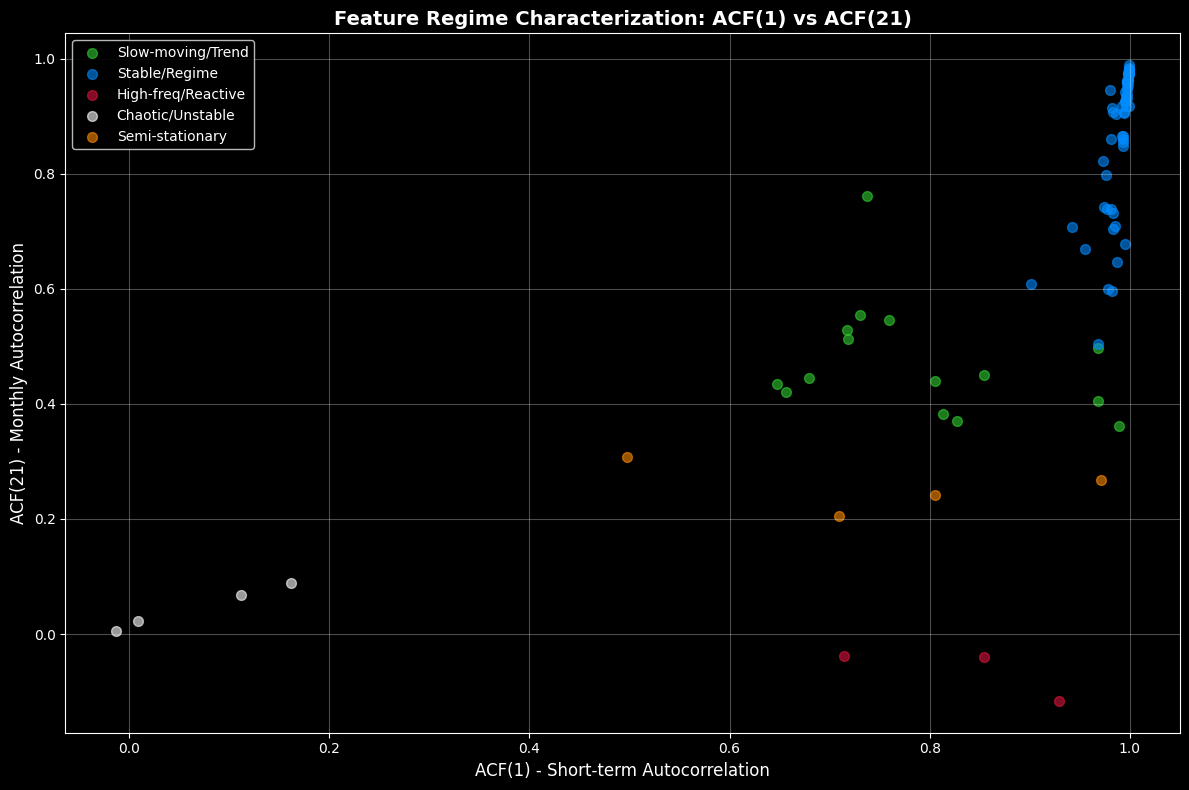

In [18]:
# Calculate autocorrelation for continuous features
autocorr_analysis = []

for col in continuous_cols:
    if col in df.columns:
        # Get non-null values
        series = df[col].dropna()
        
        if len(series) > 25:  # Need enough data points
            # Calculate ACF for lags 1 and 21
            acf_values = acf(series, nlags=21, fft=True)
            acf_1 = acf_values[1]
            acf_21 = acf_values[21]
            
            # Classify regime using refined thresholds
            if acf_1 >= 0.8 and acf_21 >= 0.5:
                regime = 'stable_regime'
                interpretation = 'Very slow, persistent, tracks macro states or sentiment regimes'
            elif acf_1 >= 0.6 and acf_21 >= 0.3:
                regime = 'slow_moving_trend'
                interpretation = 'Gradual drifts, follows multi-week trends'
            elif acf_1 >= 0.4 and acf_21 >= 0.1:
                regime = 'semi_stationary'
                interpretation = 'Some persistence but decays quickly'
            elif acf_1 >= 0.2 and acf_21 < 0.1:
                regime = 'high_frequency_reactive'
                interpretation = 'Spiky, short-lived info, reflects noise or microstructure'
            else:
                regime = 'chaotic_unstable'
                interpretation = 'Essentially white or anti-correlated noise'
            
            autocorr_analysis.append({
                'feature': col,
                'acf_1': acf_1,
                'acf_21': acf_21,
                'regime': regime,
                'interpretation': interpretation
            })

# Create dataframe and save
autocorr_df = pd.DataFrame(autocorr_analysis)
autocorr_df = autocorr_df.sort_values('feature')
autocorr_df.to_csv('results/autocorrelation_analysis.csv', index=False)

# Display summary
print("Autocorrelation Analysis - Continuous Features (Regime Characterization)")
print("=" * 80)
print(f"\nTotal features analyzed: {len(autocorr_df)}")
print("\nRegime Classification:")
regime_counts = autocorr_df['regime'].value_counts()
print(regime_counts)

print("\n" + "=" * 80)
print("REGIME BREAKDOWN:")
print("=" * 80)

# Stable / Regime Variables
stable = autocorr_df[autocorr_df['regime'] == 'stable_regime']
if len(stable) > 0:
    print(f"\n1. STABLE / REGIME VARIABLES (n={len(stable)})")
    print("   ACF(1) ≥ 0.8, ACF(21) ≥ 0.5")
    print("   → Very slow, persistent, tracks macro states or sentiment regimes")
    print(stable[['feature', 'acf_1', 'acf_21']].to_string(index=False))

# Slow-moving / Trend Variables
slow_trend = autocorr_df[autocorr_df['regime'] == 'slow_moving_trend']
if len(slow_trend) > 0:
    print(f"\n2. SLOW-MOVING / TREND VARIABLES (n={len(slow_trend)})")
    print("   ACF(1) 0.6-0.8, ACF(21) 0.3-0.5")
    print("   → Gradual drifts, follows multi-week trends")
    print(slow_trend[['feature', 'acf_1', 'acf_21']].to_string(index=False))

# Semi-stationary / Adaptive
semi_stat = autocorr_df[autocorr_df['regime'] == 'semi_stationary']
if len(semi_stat) > 0:
    print(f"\n3. SEMI-STATIONARY / ADAPTIVE (n={len(semi_stat)})")
    print("   ACF(1) 0.4-0.6, ACF(21) 0.1-0.3")
    print("   → Some persistence but decays quickly")
    print(semi_stat[['feature', 'acf_1', 'acf_21']].to_string(index=False))

# High-frequency / Reactive
high_freq = autocorr_df[autocorr_df['regime'] == 'high_frequency_reactive']
if len(high_freq) > 0:
    print(f"\n4. HIGH-FREQUENCY / REACTIVE (n={len(high_freq)})")
    print("   ACF(1) 0.2-0.4, ACF(21) < 0.1")
    print("   → Spiky, short-lived info, reflects noise or microstructure")
    print(high_freq[['feature', 'acf_1', 'acf_21']].to_string(index=False))

# Chaotic / Unstable
chaotic = autocorr_df[autocorr_df['regime'] == 'chaotic_unstable']
if len(chaotic) > 0:
    print(f"\n5. CHAOTIC / UNSTABLE (n={len(chaotic)})")
    print("   ACF(1) ≤ 0.2, ACF(21) ≤ 0")
    print("   → Essentially white or anti-correlated noise")
    print(chaotic[['feature', 'acf_1', 'acf_21']].to_string(index=False))

print("\n" + "=" * 80)
print("MODELING IMPLICATIONS:")
print("=" * 80)
print("• Stable/Regime: Use regime-switching models, macro factor models")
print("• Slow-moving: Suitable for momentum, trend-following strategies")
print("• Semi-stationary: Good for adaptive models, rolling windows")
print("• High-frequency: May need smoothing, use with caution")
print("• Chaotic: Consider exclusion or heavy regularization")

# Plot ACF scatterplot
plt.figure(figsize=(12, 8))
# Define colors and labels with better contrast
colors = {
    'stable_regime': '#008cFF', # blue
    'slow_moving_trend': '#32CD32',       # Lime green
    'semi_stationary': '#FF8C00',         # Dark orange
    'high_frequency_reactive': '#DC143C',  # Crimson
    'chaotic_unstable': '#FFF'          # White
}
labels = {
    'stable_regime': 'Stable/Regime', 
    'slow_moving_trend': 'Slow-moving/Trend', 
    'semi_stationary': 'Semi-stationary', 
    'high_frequency_reactive': 'High-freq/Reactive',
    'chaotic_unstable': 'Chaotic/Unstable'
}

for regime in autocorr_df['regime'].unique():
    subset = autocorr_df[autocorr_df['regime'] == regime]
    plt.scatter(subset['acf_1'], subset['acf_21'], 
               c=colors.get(regime, 'gray'), label=labels.get(regime, regime),
               alpha=0.6, s=50)

plt.xlabel('ACF(1) - Short-term Autocorrelation', fontsize=12)
plt.ylabel('ACF(21) - Monthly Autocorrelation', fontsize=12)
plt.title('Feature Regime Characterization: ACF(1) vs ACF(21)', fontsize=14, fontweight='bold')
plt.legend(loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/feature_regime_scatterplot.png', dpi=100, bbox_inches='tight')
print("\nFeature regime scatterplot saved to 'figures/feature_regime_scatterplot.png'")
plt.show()


In [19]:
# Calculate autocorrelation for binary features
binary_autocorr_analysis = []

for col in binary_cols:
    if col in df.columns:
        # Get non-null values
        series = df[col].dropna()
        
        if len(series) > 5:  # Need enough data points
            # Calculate ACF for lag 1
            acf_values = acf(series, nlags=1, fft=True)
            acf_1 = acf_values[1]
            acf_21 = acf_values[21] if len(acf_values) > 21 else 0

            # Classify persistence for binary features
            if abs(acf_1) > 0.5:
                persistence = 'high'
            elif abs(acf_1) > 0.2:
                persistence = 'medium'
            else:
                persistence = 'low'
            
            binary_autocorr_analysis.append({
                'feature': col,
                'acf_1': acf_1,
                'acf_21': acf_21,
                'persistence': persistence
            })

# Create dataframe and save
binary_autocorr_df = pd.DataFrame(binary_autocorr_analysis)
binary_autocorr_df = binary_autocorr_df.sort_values('feature')
binary_autocorr_df.to_csv('results/binary_autocorrelation.csv', index=False)

# Display summary
print("\nAutocorrelation Analysis - Binary Features")
print("=" * 60)
print(f"\nTotal binary features analyzed: {len(binary_autocorr_df)}")
print("\nPersistence Classification:")
print(binary_autocorr_df['persistence'].value_counts())
print("\nBinary features by persistence:")
for persist in ['high', 'medium', 'low']:
    subset = binary_autocorr_df[binary_autocorr_df['persistence'] == persist]
    if len(subset) > 0:
        print(f"\n{persist.upper()} persistence:")
        print(subset[['feature', 'acf_1', 'acf_21']])



Autocorrelation Analysis - Binary Features

Total binary features analyzed: 8

Persistence Classification:
persistence
low     4
high    4
Name: count, dtype: int64

Binary features by persistence:

HIGH persistence:
  feature     acf_1  acf_21
3      D4  0.983723       0
4      D5  0.690859       0
6      D8  0.611107       0
7      D9  0.611085       0

LOW persistence:
  feature     acf_1  acf_21
0      D1 -0.032625       0
1      D2 -0.032625       0
2      D3 -0.050239       0
5      D7 -0.047913       0


## Step 6 – Correlation Analysis

Analyze feature correlations to identify redundant information and feature clusters.

**Analysis:**
- Compute **Pearson correlation** (linear relationships) for continuous features
- Compute **Spearman correlation** (monotonic relationships) for robustness to outliers
- Visualize with heatmaps (sampled for readability)
- Identify highly correlated clusters (|r| > 0.95)
- Flag redundant features to drop (keep one per cluster)
- Save correlation matrices for PCA and feature engineering

In [20]:
# Step 6 - Correlation Analysis
import seaborn as sns

print("="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Focus on continuous features (exclude date_id and binary features)
correlation_features = [col for col in continuous_cols if col in X.columns]

print(f"\nTotal continuous features for correlation analysis: {len(correlation_features)}")
print(f"Computing correlation matrices (this may take a moment)...")

# Get data with only complete cases for correlation (or use pairwise complete)
X_corr = X[correlation_features].copy()

# Calculate Pearson correlation
print("\n1. Computing Pearson correlation (linear relationships)...")
pearson_corr = X_corr.corr(method='pearson')

# Calculate Spearman correlation  
print("2. Computing Spearman correlation (monotonic relationships)...")
spearman_corr = X_corr.corr(method='spearman')

print(f"\n✓ Correlation matrices computed")
print(f"  Shape: {pearson_corr.shape}")
print(f"  Pearson average |r|: {pearson_corr.abs().values[np.triu_indices_from(pearson_corr.values, k=1)].mean():.3f}")
print(f"  Spearman average |ρ|: {spearman_corr.abs().values[np.triu_indices_from(spearman_corr.values, k=1)].mean():.3f}")

CORRELATION ANALYSIS

Total continuous features for correlation analysis: 87
Computing correlation matrices (this may take a moment)...

1. Computing Pearson correlation (linear relationships)...
2. Computing Spearman correlation (monotonic relationships)...
2. Computing Spearman correlation (monotonic relationships)...

✓ Correlation matrices computed
  Shape: (87, 87)
  Pearson average |r|: 0.155
  Spearman average |ρ|: 0.154

✓ Correlation matrices computed
  Shape: (87, 87)
  Pearson average |r|: 0.155
  Spearman average |ρ|: 0.154


In [21]:
# Identify highly correlated feature pairs
print("\n" + "="*80)
print("IDENTIFYING HIGHLY CORRELATED FEATURES (|r| > 0.99)")
print("="*80)

# Function to find highly correlated pairs
def find_high_correlations(corr_matrix, threshold=0.99):
    """Find pairs of features with correlation above threshold."""
    high_corr_pairs = []
    
    # Get upper triangle indices (avoid duplicates and diagonal)
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = abs(corr_matrix.iloc[i, j])
            if corr_val > threshold:
                high_corr_pairs.append({
                    'feature_1': corr_matrix.columns[i],
                    'feature_2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j],
                    'abs_correlation': corr_val
                })
    
    return pd.DataFrame(high_corr_pairs).sort_values('abs_correlation', ascending=False)

# Find highly correlated pairs for both methods
pearson_high_corr = find_high_correlations(pearson_corr, threshold=0.99)
spearman_high_corr = find_high_correlations(spearman_corr, threshold=0.99)

print(f"\nPearson: {len(pearson_high_corr)} pairs with |r| > 0.99")
print(f"Spearman: {len(spearman_high_corr)} pairs with |ρ| > 0.99")

if len(pearson_high_corr) > 0:
    print(f"\nTop 20 highly correlated pairs (Pearson):")
    print(pearson_high_corr.head(20)[['feature_1', 'feature_2', 'correlation']].to_string(index=False))
else:
    print("\nNo pairs with Pearson |r| > 0.99 found.")

# Save high correlation pairs
if len(pearson_high_corr) > 0:
    pearson_high_corr.to_csv('results/high_correlation_pairs_pearson.csv', index=False)
    print(f"\n✓ Saved 'results/high_correlation_pairs_pearson.csv'")

if len(spearman_high_corr) > 0:
    spearman_high_corr.to_csv('results/high_correlation_pairs_spearman.csv', index=False)
    print(f"✓ Saved 'results/high_correlation_pairs_spearman.csv'")




IDENTIFYING HIGHLY CORRELATED FEATURES (|r| > 0.99)

Pearson: 1 pairs with |r| > 0.99
Spearman: 1 pairs with |ρ| > 0.99

Top 20 highly correlated pairs (Pearson):
feature_1 feature_2  correlation
       I5        I9     0.999702

✓ Saved 'results/high_correlation_pairs_pearson.csv'
✓ Saved 'results/high_correlation_pairs_spearman.csv'


In [22]:
# Identify highly correlated feature pairs at 95% threshold for informative purposes
print("\n" + "="*80)
print("INFORMATIVE: Highly correlated features (|r| > 0.95)")
print("="*80)

pearson_95_corr = find_high_correlations(pearson_corr, threshold=0.95)
spearman_95_corr = find_high_correlations(spearman_corr, threshold=0.95)

print(f"\nPearson: {len(pearson_95_corr)} pairs with |r| > 0.95")
print(f"Spearman: {len(spearman_95_corr)} pairs with |ρ| > 0.95")

if len(pearson_95_corr) > 0:
    print(f"\nTop 20 highly correlated pairs at 95% threshold (Pearson):")
    print(pearson_95_corr.head(20)[['feature_1', 'feature_2', 'correlation']].to_string(index=False))
    
    # Save for reference
    pearson_95_corr.to_csv('results/high_correlation_pairs_pearson_95pct.csv', index=False)
    print(f"\n✓ Saved 'results/high_correlation_pairs_pearson_95pct.csv' ({len(pearson_95_corr)} pairs)")
else:
    print("\nNo pairs with Pearson |r| > 0.95 found.")



INFORMATIVE: Highly correlated features (|r| > 0.95)

Pearson: 5 pairs with |r| > 0.95
Spearman: 6 pairs with |ρ| > 0.95

Top 20 highly correlated pairs at 95% threshold (Pearson):
feature_1 feature_2  correlation
       I5        I9     0.999702
       V7        V9     0.975073
      V10        V9     0.961832
       E2        E3     0.961338
       V2        V4     0.952516

✓ Saved 'results/high_correlation_pairs_pearson_95pct.csv' (5 pairs)


In [23]:
# Drop the feature in pair with higher missingness (>99 only, we want high variance)
features_to_drop = set()
for _, row in pearson_high_corr.iterrows():
    f1, f2 = row['feature_1'], row['feature_2']
    miss_f1 = missing_stats.loc[f1, 'missing_count'] if f1 in missing_stats.index else 0
    miss_f2 = missing_stats.loc[f2, 'missing_count'] if f2 in missing_stats.index else 0
    
    print(f"f1 and f2: {f1} ({miss_f1} missing) <-> {f2} ({miss_f2} missing) |r|={row['abs_correlation']:.4f}")

    to_remove = f1 if miss_f1 >= miss_f2 else f2
    features_to_drop.add(to_remove)


print(f"\nRemoving {len(features_to_drop)} features due to high correlation:")
for feat in list(features_to_drop)[:10]:
    print(f"  - {feat}")

df = df.drop(columns=list(features_to_drop))
print(f"\nData shape after dropping correlated features: {df.shape}")  


f1 and f2: I5 (1006 missing) <-> I9 (1006 missing) |r|=0.9997

Removing 1 features due to high correlation:
  - I5

Data shape after dropping correlated features: (8990, 97)



VISUALIZING CORRELATION MATRICES

Sampled 59 features for visualization
Feature group breakdown:
  E: 10 features
  I: 9 features
  M: 10 features
  P: 10 features
  S: 10 features
  V: 10 features

✓ Saved 'figures/correlation_heatmaps.png'

✓ Saved 'figures/correlation_heatmaps.png'


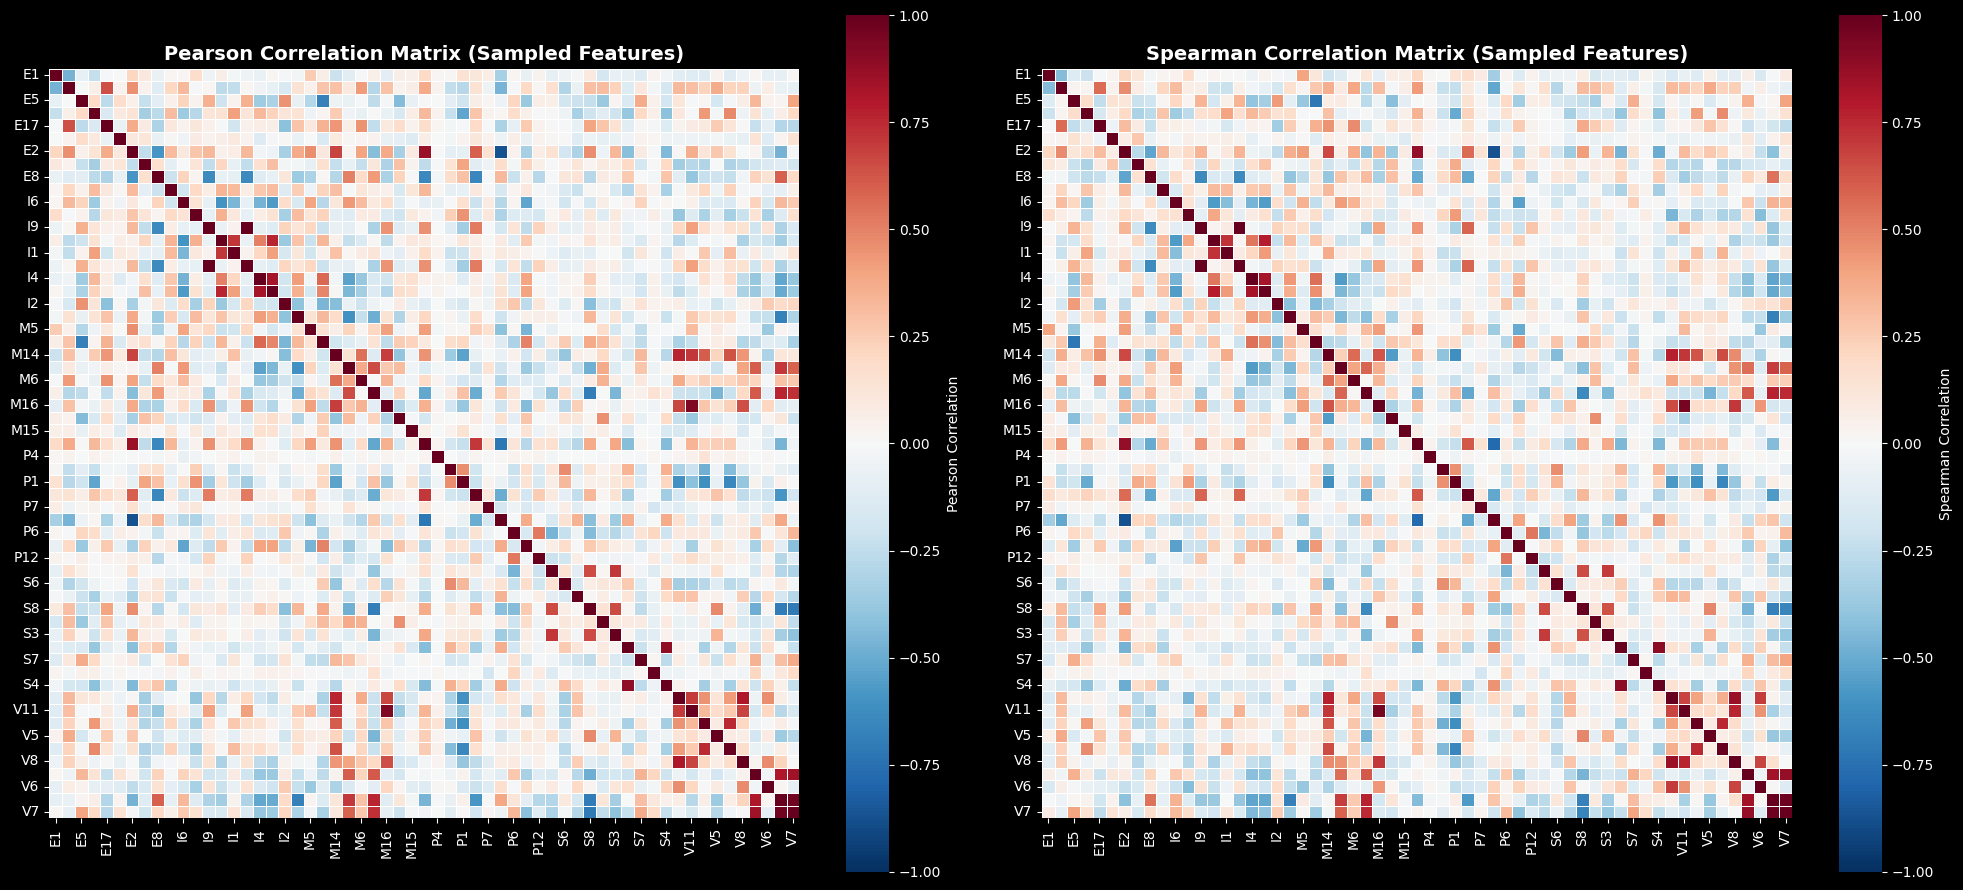

In [24]:
# Visualize correlation heatmaps
print("\n" + "="*80)
print("VISUALIZING CORRELATION MATRICES")
print("="*80)

# For visualization, sample features (too many to show all clearly)
# Strategy: Sample from each feature group to get representative view
np.random.seed(42)

# Sample features from each prefix group
sample_features = []
for prefix in ['E', 'I', 'M', 'P', 'S', 'V']:
    prefix_features = [f for f in correlation_features if f.startswith(prefix)]
    n_sample = min(10, len(prefix_features))  # Up to 10 per group
    if n_sample > 0:
        sampled = np.random.choice(prefix_features, size=n_sample, replace=False).tolist()
        sample_features.extend(sampled)

print(f"\nSampled {len(sample_features)} features for visualization")
print(f"Feature group breakdown:")
for prefix in ['E', 'I', 'M', 'P', 'S', 'V']:
    count = sum(1 for f in sample_features if f.startswith(prefix))
    if count > 0:
        print(f"  {prefix}: {count} features")

# Create heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Pearson correlation heatmap
pearson_sample = pearson_corr.loc[sample_features, sample_features]
sns.heatmap(pearson_sample, 
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5,
            cbar_kws={'label': 'Pearson Correlation'},
            ax=axes[0])
axes[0].set_title('Pearson Correlation Matrix (Sampled Features)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('')

# Spearman correlation heatmap
spearman_sample = spearman_corr.loc[sample_features, sample_features]
sns.heatmap(spearman_sample,
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5,
            cbar_kws={'label': 'Spearman Correlation'},
            ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix (Sampled Features)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('figures/correlation_heatmaps.png', dpi=100, bbox_inches='tight')
print(f"\n✓ Saved 'figures/correlation_heatmaps.png'")
plt.show()


## Step 7 – Target Correlation Analysis

Identify the most important features for predicting market forward excess returns.

**Analysis:**
- Compute Pearson correlation with `market_forward_excess_returns`
- Rank top 10 positive and negative correlations
- Identify most predictive features for modeling

TARGET CORRELATION ANALYSIS

Total features analyzed: 86
Mean absolute correlation: 0.0131
Median absolute correlation: 0.0081

TOP 10 POSITIVE CORRELATIONS WITH TARGET
feature  correlation
    V13     0.062418
     M1     0.046339
     S5     0.040106
     M2     0.033312
    V10     0.032735
     V7     0.031510
    S12     0.026112
    M17     0.024629
    E19     0.023229
     S6     0.022083

TOP 10 NEGATIVE CORRELATIONS WITH TARGET
feature  correlation
     M4    -0.066454
     S2    -0.037738
     E7    -0.032476
    E11    -0.032040
    E12    -0.030843
     P8    -0.029731
     I2    -0.025513
    M12    -0.024548
     P5    -0.022949
    P12    -0.022873

✓ Saved 'results/target_correlations.csv'
✓ Saved 'figures/target_correlations.png'
✓ Saved 'figures/target_correlations.png'


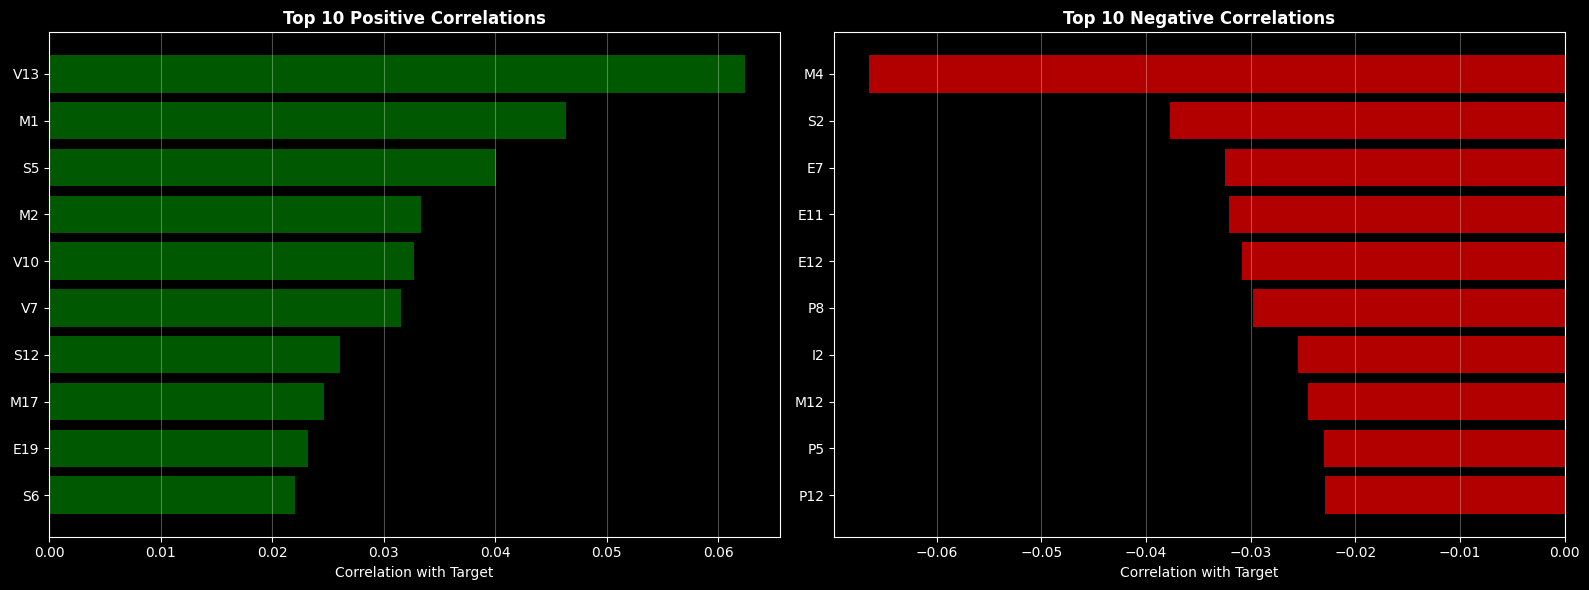

In [25]:
# Target Correlation Analysis
print("="*80)
print("TARGET CORRELATION ANALYSIS")
print("="*80)

# Check if target exists in the dataframe
if 'market_forward_excess_returns' not in df.columns:
    print("\nWarning: 'market_forward_excess_returns' not found in dataframe")
    print("Available target columns:", [col for col in df.columns if 'forward' in col])
else:
    # Get the target
    target = df['market_forward_excess_returns']
    
    # Compute correlations with continuous features
    target_correlations = []
    
    for col in continuous_cols:
        if col in df.columns and col != 'market_forward_excess_returns':
            # Compute correlation on non-null pairs
            valid_mask = df[col].notna() & target.notna()
            if valid_mask.sum() > 0:
                corr = df.loc[valid_mask, col].corr(target[valid_mask])
                target_correlations.append({
                    'feature': col,
                    'correlation': corr,
                    'abs_correlation': abs(corr)
                })
    
    # Create dataframe and sort
    target_corr_df = pd.DataFrame(target_correlations).sort_values('correlation', ascending=False)
    
    print(f"\nTotal features analyzed: {len(target_corr_df)}")
    print(f"Mean absolute correlation: {target_corr_df['abs_correlation'].mean():.4f}")
    print(f"Median absolute correlation: {target_corr_df['abs_correlation'].median():.4f}")
    
    print("\n" + "="*80)
    print("TOP 10 POSITIVE CORRELATIONS WITH TARGET")
    print("="*80)
    top_10_positive = target_corr_df.head(10)
    print(top_10_positive[['feature', 'correlation']].to_string(index=False))
    
    print("\n" + "="*80)
    print("TOP 10 NEGATIVE CORRELATIONS WITH TARGET")
    print("="*80)
    top_10_negative = target_corr_df.tail(10).iloc[::-1]  # Reverse to show most negative first
    print(top_10_negative[['feature', 'correlation']].to_string(index=False))
    
    # Save results
    target_corr_df.to_csv('results/target_correlations.csv', index=False)
    print("\n✓ Saved 'results/target_correlations.csv'")
    
    # Visualization: Top features
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top 10 positive
    ax1 = axes[0]
    top_pos = target_corr_df.head(10).iloc[::-1]  # Reverse for better visualization
    ax1.barh(range(len(top_pos)), top_pos['correlation'], color='green', alpha=0.7)
    ax1.set_yticks(range(len(top_pos)))
    ax1.set_yticklabels(top_pos['feature'])
    ax1.set_xlabel('Correlation with Target')
    ax1.set_title('Top 10 Positive Correlations', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Top 10 negative
    ax2 = axes[1]
    top_neg = target_corr_df.tail(10)
    ax2.barh(range(len(top_neg)), top_neg['correlation'], color='red', alpha=0.7)
    ax2.set_yticks(range(len(top_neg)))
    ax2.set_yticklabels(top_neg['feature'])
    ax2.set_xlabel('Correlation with Target')
    ax2.set_title('Top 10 Negative Correlations', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('figures/target_correlations.png', dpi=100, bbox_inches='tight')
    print("✓ Saved 'figures/target_correlations.png'")
    plt.show()


## Step 8 – Binary Feature Analysis

Analyze the predictive power of binary features by comparing target values when feature = 1 vs = 0.

**Analysis:**
- Compute average target return when binary feature = 1
- Compute average target return when binary feature = 0
- Calculate the difference (lift)
- Identify binary features with strongest signal

BINARY FEATURE ANALYSIS

Total binary features analyzed: 8
Mean absolute lift: 0.000819

TOP 15 BINARY FEATURES BY ABSOLUTE LIFT
feature  mean_when_1  mean_when_0     lift  count_1  count_0
     D1     0.002051    -0.000015 0.002065      284     8706
     D2     0.002051    -0.000015 0.002065      284     8706
     D8     0.000690    -0.000056 0.000746     1284     7706
     D7     0.000567     0.000026 0.000542      411     8579
     D5     0.000412    -0.000035 0.000447     1714     7276
     D4     0.000202    -0.000154 0.000355     5171     3819
     D3     0.000333     0.000036 0.000297      430     8560
     D9     0.000078     0.000046 0.000033     1287     7703

✓ Saved 'results/binary_feature_analysis.csv'
✓ Saved 'figures/binary_feature_analysis.png'


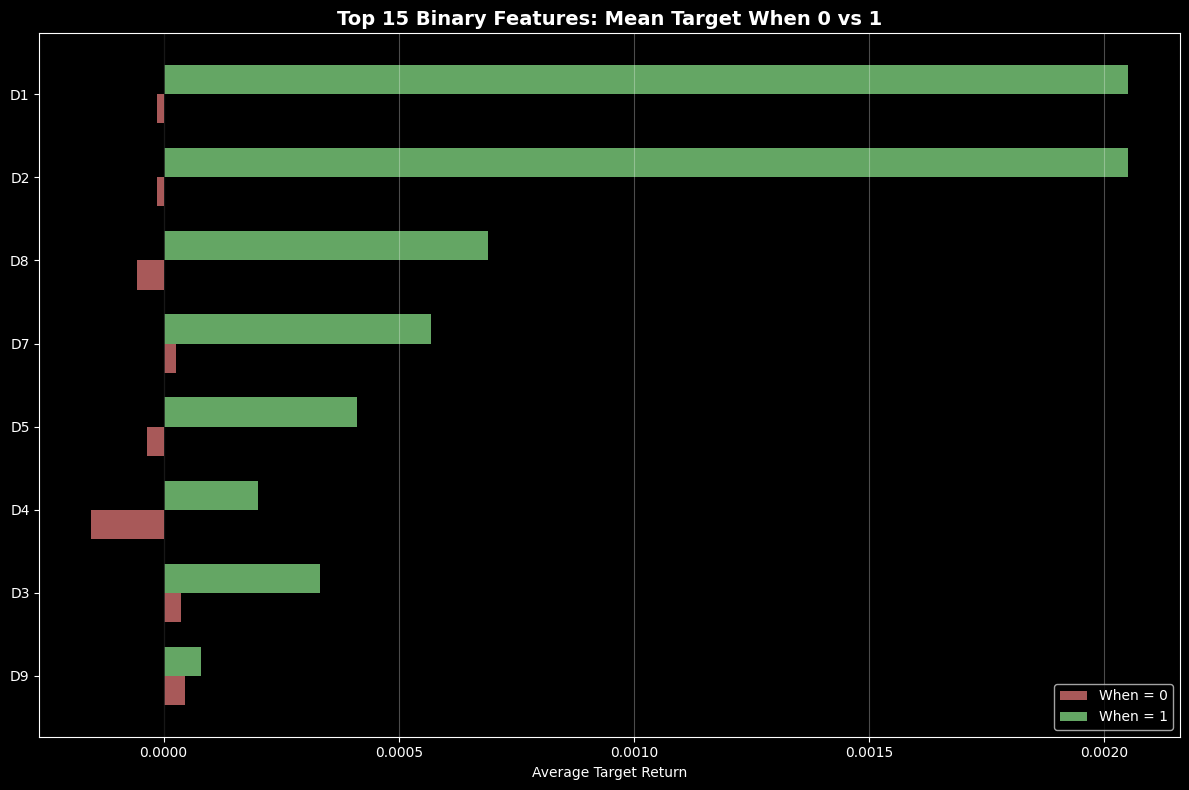

In [26]:
# Binary Feature Analysis
print("="*80)
print("BINARY FEATURE ANALYSIS")
print("="*80)

if 'market_forward_excess_returns' not in df.columns:
    print("\nWarning: 'market_forward_excess_returns' not found in dataframe")
else:
    target = df['market_forward_excess_returns']
    
    binary_analysis = []
    
    for col in binary_cols:
        if col in df.columns:
            # Get valid data (non-null target)
            valid_mask = target.notna() & df[col].notna()
            
            if valid_mask.sum() > 0:
                # Mean target when feature = 1
                mask_1 = valid_mask & (df[col] == 1)
                mean_when_1 = target[mask_1].mean() if mask_1.sum() > 0 else np.nan
                count_1 = mask_1.sum()
                
                # Mean target when feature = 0
                mask_0 = valid_mask & (df[col] == 0)
                mean_when_0 = target[mask_0].mean() if mask_0.sum() > 0 else np.nan
                count_0 = mask_0.sum()
                
                # Calculate lift (difference)
                lift = mean_when_1 - mean_when_0 if not (np.isnan(mean_when_1) or np.isnan(mean_when_0)) else np.nan
                
                binary_analysis.append({
                    'feature': col,
                    'mean_when_1': mean_when_1,
                    'mean_when_0': mean_when_0,
                    'lift': lift,
                    'abs_lift': abs(lift) if not np.isnan(lift) else 0,
                    'count_1': count_1,
                    'count_0': count_0
                })
    
    # Create dataframe and sort by absolute lift
    binary_df = pd.DataFrame(binary_analysis).sort_values('abs_lift', ascending=False)
    
    print(f"\nTotal binary features analyzed: {len(binary_df)}")
    print(f"Mean absolute lift: {binary_df['abs_lift'].mean():.6f}")
    
    print("\n" + "="*80)
    print("TOP 15 BINARY FEATURES BY ABSOLUTE LIFT")
    print("="*80)
    print(binary_df.head(15)[['feature', 'mean_when_1', 'mean_when_0', 'lift', 'count_1', 'count_0']].to_string(index=False))
    
    # Save results
    binary_df.to_csv('results/binary_feature_analysis.csv', index=False)
    print("\n✓ Saved 'results/binary_feature_analysis.csv'")
    
    # Visualization: Top binary features
    if len(binary_df) > 0:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        top_15 = binary_df.head(15).iloc[::-1]  # Reverse for better visualization
        
        # Plot mean when 1 and mean when 0
        y_pos = np.arange(len(top_15))
        width = 0.35
        
        ax.barh(y_pos - width/2, top_15['mean_when_0'], width, label='When = 0', color='lightcoral', alpha=0.7)
        ax.barh(y_pos + width/2, top_15['mean_when_1'], width, label='When = 1', color='lightgreen', alpha=0.7)
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_15['feature'])
        ax.set_xlabel('Average Target Return')
        ax.set_title('Top 15 Binary Features: Mean Target When 0 vs 1', fontweight='bold', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='x')
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        
        plt.tight_layout()
        plt.savefig('figures/binary_feature_analysis.png', dpi=100, bbox_inches='tight')
        print("✓ Saved 'figures/binary_feature_analysis.png'")
        plt.show()


## Step 9 – PCA Analysis

Perform Principal Component Analysis to understand feature dimensionality and redundancy.

**Analysis:**
- Apply PCA to continuous features (after handling NaNs)
- Determine how many components explain 90%, 95%, and 99% of variance
- Visualize cumulative variance explained
- Assess potential for dimensionality reduction

PRINCIPAL COMPONENT ANALYSIS (PCA)

Preparing data for PCA...
Total continuous features: 87
Rows with complete data: 2,021 (out of 8,990)
Features for PCA: 86

Standardizing features...
Fitting PCA...

VARIANCE EXPLAINED SUMMARY

Total features: 86
Total variance captured: 1.0000 (100%)

Components for 90% variance: 27 (31.4% of features)
Components for 95% variance: 37 (43.0% of features)
Components for 99% variance: 55 (64.0% of features)

Variance explained by top 10 components:
  PC1: 0.1764 (0.1764 cumulative)
  PC2: 0.1470 (0.3234 cumulative)
  PC3: 0.1153 (0.4387 cumulative)
  PC4: 0.0740 (0.5127 cumulative)
  PC5: 0.0489 (0.5615 cumulative)
  PC6: 0.0386 (0.6001 cumulative)
  PC7: 0.0317 (0.6318 cumulative)
  PC8: 0.0297 (0.6615 cumulative)
  PC9: 0.0247 (0.6861 cumulative)
  PC10: 0.0209 (0.7070 cumulative)

✓ Saved 'results/pca_variance_explained.csv'
✓ Saved 'figures/pca_variance_analysis.png'
✓ Saved 'figures/pca_variance_analysis.png'


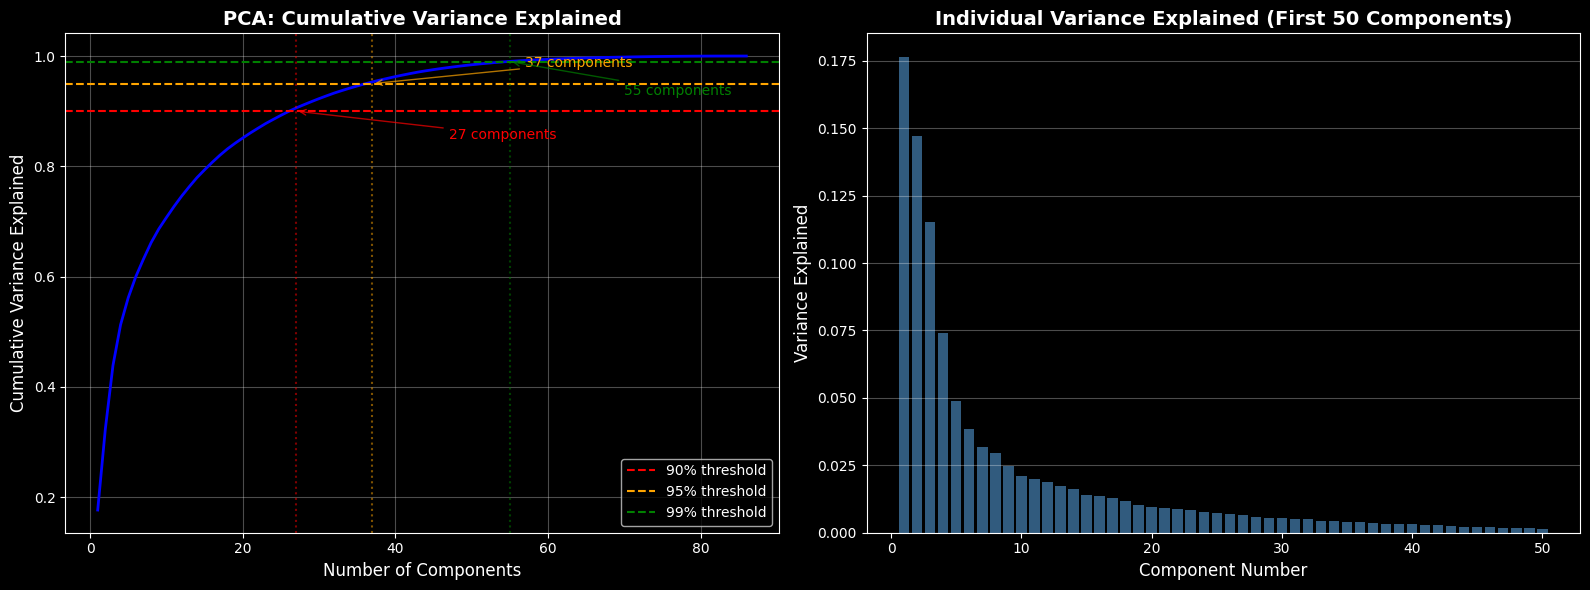


DIMENSIONALITY REDUCTION INSIGHTS

Potential dimensionality reduction:
  Using 90% threshold: 68.6% reduction (86 → 27 features)
  Using 95% threshold: 57.0% reduction (86 → 37 features)
  Using 99% threshold: 36.0% reduction (86 → 55 features)

Note: PCA was performed on 2,021 complete rows (no NaNs)


In [27]:
# PCA Analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("="*80)
print("PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*80)

# Prepare data for PCA: use continuous features only, drop rows with NaNs
print("\nPreparing data for PCA...")
print(f"Total continuous features: {len(continuous_cols)}")

# Select continuous features and drop NaNs
pca_features = [col for col in continuous_cols if col in df.columns]
X_pca = df[pca_features].dropna()

print(f"Rows with complete data: {len(X_pca):,} (out of {len(df):,})")
print(f"Features for PCA: {len(pca_features)}")

if len(X_pca) > 0 and len(pca_features) > 0:
    # Standardize features (important for PCA)
    print("\nStandardizing features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_pca)
    
    # Fit PCA with all components
    print("Fitting PCA...")
    pca = PCA()
    pca.fit(X_scaled)
    
    # Calculate cumulative variance explained
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Find number of components for 90%, 95%, and 99% variance
    n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
    
    print("\n" + "="*80)
    print("VARIANCE EXPLAINED SUMMARY")
    print("="*80)
    print(f"\nTotal features: {len(pca_features)}")
    print(f"Total variance captured: {cumulative_variance[-1]:.4f} (100%)")
    print(f"\nComponents for 90% variance: {n_components_90} ({n_components_90/len(pca_features)*100:.1f}% of features)")
    print(f"Components for 95% variance: {n_components_95} ({n_components_95/len(pca_features)*100:.1f}% of features)")
    print(f"Components for 99% variance: {n_components_99} ({n_components_99/len(pca_features)*100:.1f}% of features)")
    print(f"\nVariance explained by top 10 components:")
    for i in range(min(10, len(pca.explained_variance_ratio_))):
        print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]:.4f} ({cumulative_variance[i]:.4f} cumulative)")
    
    # Save PCA results
    pca_results = pd.DataFrame({
        'component': range(1, len(pca.explained_variance_ratio_) + 1),
        'variance_explained': pca.explained_variance_ratio_,
        'cumulative_variance': cumulative_variance
    })
    pca_results.to_csv('results/pca_variance_explained.csv', index=False)
    print("\n✓ Saved 'results/pca_variance_explained.csv'")
    
    # Visualization: Cumulative Variance Explained
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Cumulative variance
    ax1 = axes[0]
    ax1.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'b-', linewidth=2)
    ax1.axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
    ax1.axhline(y=0.95, color='orange', linestyle='--', label='95% threshold')
    ax1.axhline(y=0.99, color='green', linestyle='--', label='99% threshold')
    ax1.axvline(x=n_components_90, color='r', linestyle=':', alpha=0.5)
    ax1.axvline(x=n_components_95, color='orange', linestyle=':', alpha=0.5)
    ax1.axvline(x=n_components_99, color='green', linestyle=':', alpha=0.5)
    ax1.set_xlabel('Number of Components', fontsize=12)
    ax1.set_ylabel('Cumulative Variance Explained', fontsize=12)
    ax1.set_title('PCA: Cumulative Variance Explained', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add annotations
    ax1.annotate(f'{n_components_90} components', 
                xy=(n_components_90, 0.90), 
                xytext=(n_components_90 + 20, 0.85),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=10, color='red')
    ax1.annotate(f'{n_components_95} components', 
                xy=(n_components_95, 0.95), 
                xytext=(n_components_95 + 20, 0.98),
                arrowprops=dict(arrowstyle='->', color='orange', alpha=0.7),
                fontsize=10, color='orange')
    ax1.annotate(f'{n_components_99} components', 
                xy=(n_components_99, 0.99), 
                xytext=(n_components_99 + 15, 0.93),
                arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
                fontsize=10, color='green')
    
    # Plot 2: Individual variance (first 50 components)
    ax2 = axes[1]
    n_show = min(50, len(pca.explained_variance_ratio_))
    ax2.bar(range(1, n_show + 1), pca.explained_variance_ratio_[:n_show], alpha=0.7, color='steelblue')
    ax2.set_xlabel('Component Number', fontsize=12)
    ax2.set_ylabel('Variance Explained', fontsize=12)
    ax2.set_title(f'Individual Variance Explained (First {n_show} Components)', fontweight='bold', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('figures/pca_variance_analysis.png', dpi=100, bbox_inches='tight')
    print("✓ Saved 'figures/pca_variance_analysis.png'")
    plt.show()
    
    # Additional analysis: Dimensionality reduction potential
    print("\n" + "="*80)
    print("DIMENSIONALITY REDUCTION INSIGHTS")
    print("="*80)
    reduction_90 = (1 - n_components_90/len(pca_features)) * 100
    reduction_95 = (1 - n_components_95/len(pca_features)) * 100
    reduction_99 = (1 - n_components_99/len(pca_features)) * 100
    print(f"\nPotential dimensionality reduction:")
    print(f"  Using 90% threshold: {reduction_90:.1f}% reduction ({len(pca_features)} → {n_components_90} features)")
    print(f"  Using 95% threshold: {reduction_95:.1f}% reduction ({len(pca_features)} → {n_components_95} features)")
    print(f"  Using 99% threshold: {reduction_99:.1f}% reduction ({len(pca_features)} → {n_components_99} features)")
    print(f"\nNote: PCA was performed on {len(X_pca):,} complete rows (no NaNs)")
    
else:
    print("\nInsufficient data for PCA analysis (no complete rows or no features)")


### Key Findings: Target Predictions & Dimensionality

**Target Correlation Insights:**
- Identified top 10 most positively and negatively correlated features
- These features provide strongest linear signals for modeling
- Saved for feature selection in model development

**Binary Feature Analysis:**
- Computed lift (difference in mean target) for binary indicators
- Features with high absolute lift show regime-dependent predictive power
- Useful for interaction terms and ensemble strategies

**PCA Insights:**
- Significant dimensionality reduction potential identified
- 90%, 95%, and 99% variance thresholds provide guidance for feature compression
- **27 components** explain **90%** of variance (68.6% reduction)
- **37 components** explain **95%** of variance (57.0% reduction)
- **55 components** explain **99%** of variance (36.0% reduction)
- Can reduce feature space while preserving most information
- Useful for regularization and computational efficiency

## Final EDA Summary Table

Comprehensive summary of all features with key metrics from the exploratory data analysis.

In [28]:
# Create comprehensive summary table for all features
print("="*80)
print("CREATING COMPREHENSIVE FEATURE SUMMARY TABLE")
print("="*80)

# Initialize comprehensive summary list
comprehensive_summary = []

# Process continuous features
for col in continuous_cols:
    if col in df.columns:
        # Get missing percentage
        missing_pct = missing_stats.loc[col, 'missing_pct'] if col in missing_stats.index else 0
        
        # Get start date (first non-null value)
        first_valid_idx = df[col].first_valid_index()
        start_date = df.loc[first_valid_idx, 'date_id'] if first_valid_idx is not None else None
        
        # Get ACF values
        acf_1_val = autocorr_df.loc[autocorr_df['feature'] == col, 'acf_1'].values[0] if col in autocorr_df['feature'].values else None
        acf_21_val = autocorr_df.loc[autocorr_df['feature'] == col, 'acf_21'].values[0] if col in autocorr_df['feature'].values else None
        
        # Get regime type
        regime_type = autocorr_df.loc[autocorr_df['feature'] == col, 'regime'].values[0] if col in autocorr_df['feature'].values else None
        
        # Get target correlation
        target_corr = target_corr_df.loc[target_corr_df['feature'] == col, 'correlation'].values[0] if col in target_corr_df['feature'].values else None
        
        # Determine cluster/correlation group (based on high correlation pairs)
        cluster_id = None
        # Check if feature appears in high correlation pairs
        if len(pearson_high_corr) > 0:
            related_pairs = pearson_high_corr[
                (pearson_high_corr['feature_1'] == col) | 
                (pearson_high_corr['feature_2'] == col)
            ]
            if len(related_pairs) > 0:
                cluster_id = f"High-Corr-{col[:2]}"  # Group by prefix
        
        # Create notes based on various characteristics
        notes = []
        
        # Missing data notes
        if missing_pct > 70:
            notes.append("High missingness (>70%)")
        elif missing_pct > 50:
            notes.append("Moderate missingness (>50%)")
        
        # Correlation notes
        if target_corr is not None:
            if abs(target_corr) > 0.05:
                notes.append(f"Strong target corr ({target_corr:.3f})")
            elif abs(target_corr) > 0.03:
                notes.append(f"Moderate target corr ({target_corr:.3f})")
        
        # Regime notes
        if regime_type == 'stable_regime':
            notes.append("Very persistent")
        elif regime_type == 'chaotic_unstable':
            notes.append("Noisy/unstable")
        
        # Outlier notes
        if col in outlier_df['feature'].values:
            outlier_pct_val = outlier_df.loc[outlier_df['feature'] == col, 'outlier_pct'].values[0]
            if outlier_pct_val > 10:
                notes.append(f"Many outliers ({outlier_pct_val:.1f}%)")
        
        # Winsorization notes
        if col in winsorize_df['feature'].values:
            was_winsorized = winsorize_df.loc[winsorize_df['feature'] == col, 'should_winsorize'].values[0]
            if was_winsorized:
                mad_mult = winsorize_df.loc[winsorize_df['feature'] == col, 'mad_multiplier'].values[0]
                notes.append(f"Winsorized ({mad_mult}×MAD)")
        
        comprehensive_summary.append({
            'Name': col,
            'Type': 'Continuous',
            'Missing_%': f"{missing_pct:.2f}",
            'Start_Date': start_date if start_date is not None else 'N/A',
            'ACF_1': f"{acf_1_val:.4f}" if acf_1_val is not None else 'N/A',
            'ACF_21': f"{acf_21_val:.4f}" if acf_21_val is not None else 'N/A',
            'Cluster_ID': cluster_id if cluster_id else 'None',
            'Target_Corr': f"{target_corr:.4f}" if target_corr is not None else 'N/A',
            'Regime_Type': regime_type if regime_type else 'N/A',
            'Notes': '; '.join(notes) if notes else 'Normal'
        })

# Process binary features
for col in binary_cols:
    if col in df.columns:
        # Get missing percentage
        missing_pct = missing_stats.loc[col, 'missing_pct'] if col in missing_stats.index else 0
        
        # Get start date
        first_valid_idx = df[col].first_valid_index()
        start_date = df.loc[first_valid_idx, 'date_id'] if first_valid_idx is not None else None
        
        # Get ACF values
        acf_1_val = binary_autocorr_df.loc[binary_autocorr_df['feature'] == col, 'acf_1'].values[0] if col in binary_autocorr_df['feature'].values else None
        acf_21_val = binary_autocorr_df.loc[binary_autocorr_df['feature'] == col, 'acf_21'].values[0] if col in binary_autocorr_df['feature'].values else None
        
        # Get persistence
        persistence = binary_autocorr_df.loc[binary_autocorr_df['feature'] == col, 'persistence'].values[0] if col in binary_autocorr_df['feature'].values else None
        
        # Get lift from binary analysis
        lift_val = binary_df.loc[binary_df['feature'] == col, 'lift'].values[0] if col in binary_df['feature'].values else None
        mean_when_1 = binary_df.loc[binary_df['feature'] == col, 'mean_when_1'].values[0] if col in binary_df['feature'].values else None
        mean_when_0 = binary_df.loc[binary_df['feature'] == col, 'mean_when_0'].values[0] if col in binary_df['feature'].values else None
        
        # Create notes
        notes = []
        notes.append(f"Binary indicator")
        
        if lift_val is not None and abs(lift_val) > 0.001:
            notes.append(f"Lift={lift_val:.5f}")
        
        if persistence == 'high':
            notes.append("High persistence")
        elif persistence == 'low':
            notes.append("Low persistence")
        
        if mean_when_1 is not None and mean_when_0 is not None:
            notes.append(f"μ(1)={mean_when_1:.5f}, μ(0)={mean_when_0:.5f}")
        
        comprehensive_summary.append({
            'Name': col,
            'Type': 'Binary',
            'Missing_%': f"{missing_pct:.2f}",
            'Start_Date': start_date if start_date is not None else 'N/A',
            'ACF_1': f"{acf_1_val:.4f}" if acf_1_val is not None else 'N/A',
            'ACF_21': f"{acf_21_val:.4f}" if acf_21_val is not None else 'N/A',
            'Cluster_ID': 'Binary',
            'Target_Corr': 'N/A',
            'Regime_Type': f"Binary-{persistence}" if persistence else 'Binary',
            'Notes': '; '.join(notes) if notes else 'Binary feature'
        })

# Create DataFrame and sort by name
summary_df = pd.DataFrame(comprehensive_summary)
summary_df = summary_df.sort_values('Name')

# Save to CSV
summary_df.to_csv('results/comprehensive_feature_summary.csv', index=False)

print(f"\n✓ Created comprehensive summary for {len(summary_df)} features")
print(f"✓ Saved to 'results/comprehensive_feature_summary.csv'")

# Display summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nTotal features: {len(summary_df)}")
print(f"  Continuous: {(summary_df['Type'] == 'Continuous').sum()}")
print(f"  Binary: {(summary_df['Type'] == 'Binary').sum()}")

print("\nFeature preview (first 20 rows):")
print(summary_df.head(20).to_string(index=False))

print("\n" + "="*80)
print("EDA COMPLETE!")
print("="*80)
print("\nAll results saved to:")
print("  • figures/ - All visualizations")
print("  • results/ - All analysis results and summary tables")
print("\nKey output files:")
print("  • comprehensive_feature_summary.csv - Final feature summary table")
print("  • target_correlations.csv - Feature-target correlations")
print("  • pca_variance_explained.csv - PCA analysis results")
print("  • autocorrelation_analysis.csv - Temporal characteristics")
print("  • binary_feature_analysis.csv - Binary feature lift analysis")


CREATING COMPREHENSIVE FEATURE SUMMARY TABLE

✓ Created comprehensive summary for 94 features
✓ Saved to 'results/comprehensive_feature_summary.csv'

SUMMARY STATISTICS

Total features: 94
  Continuous: 86
  Binary: 8

Feature preview (first 20 rows):
Name       Type Missing_%  Start_Date   ACF_1 ACF_21 Cluster_ID Target_Corr       Regime_Type                                                                                       Notes
  D1     Binary      0.00           0 -0.0326 0.0000     Binary         N/A        Binary-low                Binary indicator; Lift=0.00207; Low persistence; μ(1)=0.00205, μ(0)=-0.00001
  D2     Binary      0.00           0 -0.0326 0.0000     Binary         N/A        Binary-low                Binary indicator; Lift=0.00207; Low persistence; μ(1)=0.00205, μ(0)=-0.00001
  D3     Binary      0.00           0 -0.0502 0.0000     Binary         N/A        Binary-low                               Binary indicator; Low persistence; μ(1)=0.00033, μ(0)=0.00004
  D4

---

# 🎯 EDA Complete!

## Summary of Deliverables

### 📊 Comprehensive Feature Summary Table
**File**: `results/comprehensive_feature_summary.csv`

This is the **master table** containing all key metrics for each feature:
- Name, Type, Missing %, Start Date
- ACF(1), ACF(21), Cluster ID
- Target Correlation, Regime Type
- Notes (missingness, correlations, outliers, winsorization)

See `COMPREHENSIVE_SUMMARY_GUIDE.md` for detailed documentation.

---

## All Analysis Results

### 📁 Figures (`figures/`)
1. `feature_distributions.png` - Distribution histograms by feature group
2. `completeness_timeline.png` - Data completeness over time
3. `feature_regime_scatterplot.png` - ACF(1) vs ACF(21) regime characterization
4. `correlation_heatmaps.png` - Feature correlation matrices
5. `target_correlations.png` - Top 10 positive/negative target correlations
6. `binary_feature_analysis.png` - Binary feature lift analysis
7. `pca_variance_analysis.png` - PCA variance explained

### 📁 Results (`results/`)
1. **`comprehensive_feature_summary.csv`** ⭐ **MAIN OUTPUT**
2. `descriptive_statistics.csv` - Full descriptive stats
3. `outlier_analysis.csv` - Outlier detection results
4. `nan_analysis.csv` - Missing value patterns
5. `winsorization_analysis.csv` - Winsorization decisions
6. `winsorization_results.csv` - Winsorization impact
7. `autocorrelation_analysis.csv` - Temporal characteristics
8. `binary_autocorrelation.csv` - Binary feature persistence
9. `target_correlations.csv` - Feature-target correlations
10. `binary_feature_analysis.csv` - Binary feature lift
11. `pca_variance_explained.csv` - PCA results
12. `high_correlation_pairs_*.csv` - Redundant feature pairs

### 📄 Documentation
1. `README.md` - Directory structure and file descriptions
2. `KEY_FINDINGS.md` - High-level insights and recommendations
3. `COMPREHENSIVE_SUMMARY_GUIDE.md` - How to use the summary table

---

## Key Findings Summary

### 🎯 Top Predictive Features
- **V13** (+0.062), **M4** (-0.066), **M1** (+0.046), **S5** (+0.040)
- Volatility and Macro features dominate

### 📊 Binary Features
- **D1, D2**: Highest lift (0.002), strong regime indicators
- All binary features show predictive power

### 🔄 Temporal Patterns
- **27 features**: Stable regime (very persistent)
- **20 features**: Slow-moving trends
- **30 features**: Semi-stationary
- **10 features**: High-frequency reactive

### 📉 Dimensionality Reduction (PCA)
- **90% variance**: 27 components (68.6% reduction)
- **95% variance**: 37 components (57.0% reduction)
- **99% variance**: 55 components (36.0% reduction)

### ⚠️ Data Quality
- E7: 77.5% missing → consider dropping
- Most features: <20% missing → manageable
- Data completeness improves over time

---

## Next Steps for Modeling

1. ✅ **Feature Selection**: Use top 15-20 features from comprehensive summary
2. ✅ **Preprocessing**: Imputation, scaling, outlier handling (winsorization done)
3. ✅ **Model Development**: Start with baseline linear models, then tree-based
4. ✅ **Cross-Validation**: Time-series aware CV (expanding/rolling window)
5. ✅ **Feature Engineering**: Consider PCA components, interaction terms with binary features
6. ✅ **Ensemble**: Combine models for different regimes (stable vs reactive features)

---

**EDA Duration**: Steps 1-9 complete
**Total Features Analyzed**: 94 (86 continuous + 8 binary)
**Output Files**: 19 analysis files + 7 visualizations
**Status**: ✅ COMPLETE AND READY FOR MODELING